In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
import seaborn as sns
import tqdm
from sklearn.impute import SimpleImputer
%matplotlib inline

import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm.notebook import tqdm_notebook
from collections import Counter
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.linear_model import Lasso
import shap
import optuna
from sklearn.metrics import median_absolute_error
import re
import os

from IPython.display import HTML, display
import pprint

In [46]:
font = "Roboto-Regular.ttf"
pp = pprint.PrettyPrinter(indent=4, width=100)


HTML('''
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

.output {
    display: flex;
    align-items: left;
    text-align: justify;
}

</style>


<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')


<center><img src='banner_ml2.PNG'></center>

# Executive Summary

Data Science created a huge buzz as it combines multiple fields like statistics and artificial intelligence to enable a new age of learning and innovation, dubbing it as the sexiest job of the 21st century in an article by Thomas Davenport. As a field that is yet to be fully established and utilized around the globe, enthusiasts and professionals alike are curious as to what it takes to be a data scientist  and, of course, how much it actually pays and which factors play a role in increasing the pay grade.

Stack Overflow conducted a 2021 developer survey which had over 80,000 responses from neophytes to professionals. With this dataset, the team aims to understand what are the main drivers in determining a data scientist’s salary in the Asian developing countries by applying machine learning techniques. The study heavily banked on preprocessing methods as the dataset contains numerous null values and features. Once the dataset has been processed, the team performed machine learning models and an interpretability method, SHAP. 

Having XGBoost as the top performing model, the team concluded that years of coding professionally, years of coding, and company size are some of the main drivers of predicting a data scientist’s salary. Interestingly, the study revealed that there are controllable salary drivers like using Python as a programming language and pursuing a higher education are what aspiring data scientists can consider to possibly bump their salary. The overall mean absolute error (MAE) is at $8,100. Breaking it down into quartiles, it showed that the 4th quartile was pushing the MAE up since higher salaries are harder to predict. For future studies and explorations on this dataset, the team recommends factoring in data from other websites such as Glassdoor and LinkedIn, finding/generating a dataset that better represents each country, and exploring other advanced deep learning methods that may yield better predictions.


# Introduction

The future of work is data. The [Harvard Business Review](https://hbr.org/2012/10/data-scientist-the-sexiest-job-of-the-21st-century) claimed data scientist as the sexiest job of the 21st century. Together with the increase in digital transformation comes an increase in demand for data related jobs. Data scientists and data analysts, database professionals, and digital transformation specialists are examples of jobs included in top 20 job roles with increasing demand across industries.

With the rise in popularity of data science as a career, individuals who aspire to become data scientists have lingering questions about the profession. In particular, some wonder how they can become a data scientist and how they stack up relative to everyone else who aspires to pursue this profession. Sometimes, aspirants and practitioners alike experience some form of impostor syndrome throughout becoming a data scientist. As such, this study aims to look into what exactly a data scientist needs to have to demand their salaries higher than average wages. And a possible output is a recommendation for aspiring data scientists on what they can do to improve their chances best.

With the mission to empower the world to develop technology through collective knowledge, Stack Overflow has been a community for programmers to interact and share individual skills and expertise since 2008. Stack Overflow currently has a wide range of learners and expert programmers that are located in different parts of the world and have various titles/occupations associated with them. 

For this study, the team limited the scope to 33 Asian developing countries and data science-related titles/occupations. The team predicted the annual salary in US Dollars given various individual profiles using different regression models and found the global interpretation of the model using Shapley Additive exPlanations (SHAP). Additionally, the team fed a profile for an aspiring data scientist into the model in order to know the local interpretation. Finally, the team provided recommendations on how similar profiles can increase their pay grade. 


# Problem Statement
Data science is a field that is yet to be fully established and utilized around the globe, but is still revered as the sexiest job of the 21st century. With that said, can we predict the salary of a data scientist? If so, what are the key drivers to such a salary? As the demand for data scientists increases, we aim to develop a model that will aid both the employers and the applicants to be able to arrive at a fair and acceptable compensation for both parties. 

# Data
Stack Overflow conducts an [annual developers' survey](https://insights.stackoverflow.com/survey/2021) that examines all aspects of the developer experience. The important caveat to this study is the subjective nature of the data, but for simplicity’s sake, the researchers assumed the data to be true. The original dataset created from survey results of Stack Overflow has 83,439 rows and 48 features, representing 181 countries.  To guarantee that relevant features will be used, the team filtered and processed the dataset, finalizing the dataset to 1,077 rows and  146 features. As the objective of this study is to predict a data scientist’s salary and highlight the key drivers to said salary, the researchers truncated both data and features alike. For comparability’s sake with respect to the Philippines, the team only included Asian developing countries.  Narrowing this scope leaves us with 1,077 data points, representing 33 countries. With feature engineering through one-hot encoding and ordinal encoding, the final dataset had a total of 146 features. Table 1 shows the data dictionary.
 
 #### Table 1. Data Dictionary
| Features               | Type  | Description                                                                           |
|------------------------|-------|---------------------------------------------------------------------------------------|
| MainBranch             | str   | Respondent is developer or enthusiast                                                 |
| Employment             | str   | Respondent's employment status                                                        |
| Country                | str   | Country where the respondent resides                                                  |
| EdLevel                | str   | Education level of responded                                                          |
| YearsCode              | str   | Total years of coding                                                                 |
| YearsCodePro           | str   | Total years of coding professionally                                                  |
| DevType                | str   | Respondent's developer title/s (e.g. Data or business analyst, Product manager, etc.) |
| OrgSize                | str   | Organizational size of the company the respondent belongs to                          |
| LanguageHaveWorkedWith | str   | Language/s used by respondent (e.g. Python, R, etc.)                                  |
| DatabaseHaveWorkedWith | str   | Database used by respondent (e.g. MySQL, Oracle, etc.)                                |
| PlatformHaveWorkedWith | str   | Platform/s used by respondent (e.g. AWS, Google Cloud, etc.)                          |
| OpSys                  | str   | Operating systems used by respondent (e.g. BSD, MacOS, etc.)                          |
| SOPartFreq             | str   | Frequency of participation in Stack Overflow                                          |
| Age                    | str   | Respondent’s age range (e.g. 18-24 old,  25-34 old, etc.)                             |
| ConvertedCompYearly    | float | Annual compensation in US dollars                                                     |


## Load Data

In [47]:
#df_raw = pd.read_csv('C:\\Users\\JG\\jupyter directory\\AIM\\TERM3\\ML2\\group project\\stackoverflow_salary\\survey_results_public.csv')
df_raw = pd.read_csv(r'survey_results_public.csv')
df_raw

,ResponseId,MainBranch,Employment,Country,US_State,UK_Country,EdLevel,Age1stCode,LearnCode,YearsCode,...,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,SurveyLength,SurveyEase,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,NaN,NaN,"Secondary school (e.g. American high school, G...",18 - 24 years,Coding Bootcamp;Other online resources (ex: vi...,NaN,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",7,...,18-24 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,None of the above,Appropriate in length,Easy,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",NaN,...,18-24 years old,Man,No,Prefer not to say,Prefer not to say,None of the above,None of the above,Appropriate in length,Easy,NaN
3,4,I am a developer by profession,Employed full-time,Austria,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",11 - 17 years,NaN,NaN,...,35-44 years old,Man,No,Straight / Heterosexual,White or of European descent,I am deaf / hard of hearing,NaN,Appropriate in length,Neither easy nor difficult,NaN
4,5,I am a developer by profession,"Independent contractor, freelancer, or self-em...",United Kingdom of Great Britain and Northern I...,NaN,England,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",5 - 10 years,Friend or family member,17,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,NaN,Appropriate in length,Easy,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83434,83435,I am a developer by profession,Employed full-time,United States of America,Texas,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",6,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,I have a concentration and/or memory disorder ...,Appropriate in length,Easy,160500.0
83435,83436,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Benin,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,"Other online resources (ex: videos, blogs, etc...",4,...,18-24 years old,Man,No,Straight / Heterosexual,Black or of African descent,None of the above,None of the above,Appropriate in length,Easy,3960.0
83436,83437,I am a developer by profession,Employed full-time,United States of America,New Jersey,NaN,"Secondary school (e.g. American high school, G...",11 - 17 years,School,10,...,25-34 years old,Man,No,NaN,White or of European descent,None of the above,None of the above,Appropriate in length,Neither easy nor difficult,90000.0
83437,83438,I am a developer by profession,Employed full-time,Canada,NaN,NaN,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11 - 17 years,Online Courses or Certification;Books / Physic...,5,...,25-34 years old,Man,No,Straight / Heterosexual,White or of European descent,None of the above,I have a mood or emotional disorder (e.g. depr...,Appropriate in length,Neither easy nor difficult,816816.0


# Methodology
The study followed the following pipeline. First, the data was retrieved from Kaggle. Then after loading the data, the data was cleaned. After some exploratory data analysis to get the lay of the land, the study fit the cleaned data to be modeled after a train-test split of 75-25 was performed. Finally, a SHAP analysis is used to delve into feature importance for explanability purposes.

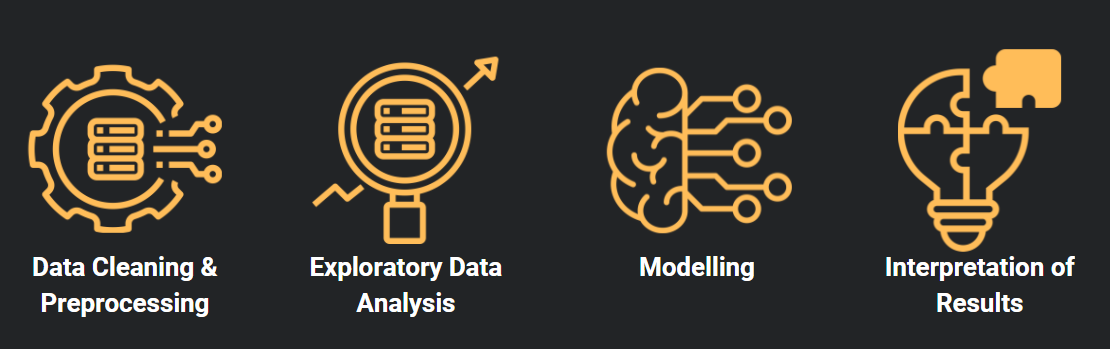

## I. Data Cleaning & Pre-processing

The group aims to narrow down the scope of the project into developing countries in Asia since the Philippines is a country of interest and narrowing down the scope to this level would allow comparability. The features are handpicked from the original features of the dataset. Further discussion on the cleaning and pre-processing is discussed in the following sections.

### I.A. Removing unwanted columns
After carefully reviewing the dataset's columns, an initial set of columns were handpicked by the group to include in our regression models. The group chose the columns that were hypothesized to have significant impact on the salary variable. The final set of features were established after many iterations of testing. 

In [48]:
cols_drop = ['US_State', 'UK_Country', 'Age1stCode', 'LearnCode', 'Currency', 
             'CompTotal', 'CompFreq', 'LanguageWantToWorkWith', 
             'DatabaseWantToWorkWith', 'PlatformWantToWorkWith', 'WebframeWantToWorkWith', 
             'WebframeHaveWorkedWith', 'MiscTechHaveWorkedWith', 'MiscTechWantToWorkWith',
             'ToolsTechHaveWorkedWith', 'ToolsTechWantToWorkWith', 'NEWCollabToolsHaveWorkedWith', 
             'NEWCollabToolsWantToWorkWith', 'NEWStuck', 'NEWSOSites', 'SOVisitFreq', 
             'SOAccount', 'SOComm', 'NEWOtherComms', 'Gender', 'Trans', 'Sexuality',
             'Ethnicity', 'Accessibility', 'MentalHealth', 'SurveyLength',
             'SurveyEase']
df_drop = df_raw.drop(columns=cols_drop, axis=0)
df_drop.head(3)

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
0,1,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Slovakia,"Secondary school (e.g. American high school, G...",NaN,NaN,"Developer, mobile",20 to 99 employees,C++;HTML/CSS;JavaScript;Objective-C;PHP;Swift,PostgreSQL;SQLite,NaN,MacOS,A few times per month or weekly,25-34 years old,62268.0
1,2,I am a student who is learning to code,"Student, full-time",Netherlands,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,NaN,NaN,NaN,JavaScript;Python,PostgreSQL,NaN,Windows,Daily or almost daily,18-24 years old,NaN
2,3,"I am not primarily a developer, but I write co...","Student, full-time",Russian Federation,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",NaN,NaN,NaN,NaN,Assembly;C;Python;R;Rust,SQLite,Heroku,MacOS,Multiple times per day,18-24 years old,NaN


In [49]:
df_drop.dropna(subset=['ConvertedCompYearly', 'YearsCode', 'YearsCodePro', 'Age', 'EdLevel', 'Employment', 'OrgSize', 'DevType'], inplace=True)

In [50]:
developing_countries = ['Russian Federation', 'India', 'Indonesia', 'Iran', 
                        'Sri Lanka', 'Georgia', 'Turkey', 'Pakistan', 'Lebanon', 
                        'Malaysia', 'China', 'Jordan', 'Uzbekistan', 
                        'Syrian Arab Republic', 'Viet Nam', 
                        "Lao People's Democratic Republic", 'Nepal', 'Philippines', 
                        'Azerbaijan', 'Armenia', 'Thailand', 'Myanmar', 'Kazakhstan', 
                        'Iraq', 'Cambodia', 'Bhutan', 'Kyrgyzstan', 'Tajikistan', 
                        'Palestine', 'Afghanistan', 'Mongolia', 'Maldives','Turkmenistan']


df_drop = df_drop[df_drop['Country'].isin(developing_countries)]
df_drop

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
16,17,I am a developer by profession,Employed full-time,Turkey,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6,2,"Developer, full-stack",100 to 499 employees,C#;HTML/CSS;Java;JavaScript;Node.js,Microsoft SQL Server;MongoDB;PostgreSQL,AWS;Google Cloud Platform,Windows,Multiple times per day,25-34 years old,17748.0
29,30,I am a developer by profession,Employed full-time,Russian Federation,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",20,16,"Developer, desktop or enterprise applications;...",2 to 9 employees,Delphi;Java;SQL,PostgreSQL,NaN,Linux-based,Multiple times per day,35-44 years old,37752.0
33,34,I am a developer by profession,Employed full-time,Turkey,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",6,2,"Developer, game or graphics",2 to 9 employees,Assembly;C;C#;C++;HTML/CSS;Java;JavaScript;Mat...,NaN,NaN,Windows,A few times per week,18-24 years old,11832.0
58,59,"I am not primarily a developer, but I write co...",Employed full-time,Russian Federation,"Professional degree (JD, MD, etc.)",5,3,"Developer, full-stack;Data scientist or machin...",20 to 99 employees,Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Oracle,Heroku,Linux-based,Less than once per month or monthly,25-34 years old,22644.0
102,103,I am a developer by profession,Employed full-time,Pakistan,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,1,"Developer, back-end;Student",20 to 99 employees,Python,NaN,AWS,Linux-based,A few times per month or weekly,18-24 years old,7788.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83399,83400,I am a developer by profession,Employed full-time,India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",7,6,"Developer, front-end",20 to 99 employees,HTML/CSS;JavaScript;TypeScript,NaN,AWS;Microsoft Azure,MacOS,A few times per week,25-34 years old,27923.0
83407,83408,I am a developer by profession,Employed full-time,Kyrgyzstan,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",4,3,"Developer, front-end","10,000 or more employees",HTML/CSS;JavaScript;TypeScript,NaN,NaN,Windows,I have never participated in Q&A on Stack Over...,25-34 years old,20616.0
83411,83412,I am a developer by profession,Employed full-time,India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",8,5,"Developer, back-end",100 to 499 employees,Java;JavaScript;SQL,MySQL,AWS,MacOS,Less than once per month or monthly,25-34 years old,48866.0
83422,83423,"I am not primarily a developer, but I write co...","Independent contractor, freelancer, or self-em...",Viet Nam,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",26,18,"Developer, full-stack","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;PHP;Ruby,MariaDB;PostgreSQL;SQLite,NaN,Linux-based,NaN,35-44 years old,20000.0


In [51]:
data_dev_list = ['Data scientist or machine learning specialist',
                 'Database administrator',
                 'Data or business analyst',
                 'Engineer, data']

ser_dev = df_drop['DevType'].str.split(';')
index_list = []
for idx, elem in ser_dev.iteritems():
    for item in elem:
        if item in data_dev_list:
            index_list.append(idx)
            break
df_devs = df_drop.loc[index_list,:]
df_devs

,ResponseId,MainBranch,Employment,Country,EdLevel,YearsCode,YearsCodePro,DevType,OrgSize,LanguageHaveWorkedWith,DatabaseHaveWorkedWith,PlatformHaveWorkedWith,OpSys,SOPartFreq,Age,ConvertedCompYearly
29,30,I am a developer by profession,Employed full-time,Russian Federation,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",20,16,"Developer, desktop or enterprise applications;...",2 to 9 employees,Delphi;Java;SQL,PostgreSQL,NaN,Linux-based,Multiple times per day,35-44 years old,37752.0
58,59,"I am not primarily a developer, but I write co...",Employed full-time,Russian Federation,"Professional degree (JD, MD, etc.)",5,3,"Developer, full-stack;Data scientist or machin...",20 to 99 employees,Bash/Shell;HTML/CSS;JavaScript;Python;SQL,Oracle,Heroku,Linux-based,Less than once per month or monthly,25-34 years old,22644.0
148,149,"I am not primarily a developer, but I write co...","Independent contractor, freelancer, or self-em...",Sri Lanka,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",2,2,Database administrator;Data or business analyst,"Just me - I am a freelancer, sole proprietor, ...",SQL,SQLite,Google Cloud Platform,Windows,Multiple times per day,25-34 years old,36000.0
154,155,I am a developer by profession,"Independent contractor, freelancer, or self-em...",India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",20,7,"Developer, front-end;Developer, full-stack;Dev...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Node.js;PHP;PowerShell;Pyt...,Firebase;MariaDB;MongoDB;MySQL;Redis,Heroku,Windows,Daily or almost daily,25-34 years old,2340.0
168,169,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Georgia,Some college/university study without earning ...,4,2,"Developer, front-end;Engineer, data;Developer,...","Just me - I am a freelancer, sole proprietor, ...",HTML/CSS;JavaScript;Python;SQL,SQLite,DigitalOcean;Heroku,Linux-based,Daily or almost daily,18-24 years old,14844.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,83047,"I am not primarily a developer, but I write co...",Employed full-time,India,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",14,11,"Developer, front-end;Developer, full-stack;Dev...",20 to 99 employees,Bash/Shell;Go;HTML/CSS;PHP;SQL,Elasticsearch;MariaDB;Redis;SQLite,AWS;DigitalOcean,MacOS,Daily or almost daily,25-34 years old,13962.0
83291,83292,I am a developer by profession,Employed full-time,India,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",5,2,"Engineer, data;Data or business analyst;Engine...","10,000 or more employees",C;HTML/CSS;Java;PowerShell;Python;SQL,Microsoft SQL Server;MySQL;Oracle;SQLite,Google Cloud Platform,Windows,A few times per week,18-24 years old,5026.0
83294,83295,I am a developer by profession,Employed full-time,Russian Federation,Some college/university study without earning ...,15,13,"Developer, back-end;Database administrator;Dev...",20 to 99 employees,Node.js;PHP,MariaDB;MySQL;PostgreSQL;SQLite,Google Cloud Platform,Windows,I have never participated in Q&A on Stack Over...,25-34 years old,30192.0
83356,83357,I am a developer by profession,"Independent contractor, freelancer, or self-em...",Indonesia,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",11,5,"Developer, mobile;Developer, front-end;Develop...","Just me - I am a freelancer, sole proprietor, ...",Bash/Shell;C;C#;C++;Dart;Go;Java;JavaScript;Ju...,Firebase;MariaDB;MongoDB;MySQL;PostgreSQL;Redi...,AWS;DigitalOcean;Google Cloud Platform;Heroku;...,Windows Subsystem for Linux (WSL),I have never participated in Q&A on Stack Over...,25-34 years old,7020.0


### I.B. OHE semicolon features
Some of the categorical features had multiple value entries which were separated by a semi-colon. Because of this, the usual and convenient way of one hot encoding was not possible. To do this, a function was made to split the values in each row with the semi-colon as the separator, create a column for each unique value, and assigned a 1 or a 0 in a column if the value associated with that column is present on that row. The features that needed this type of encoding are `LanguageHaveWorkedWith`, `DevType`, `DatabaseHaveWorkedWith`, and `PlatformHaveWorkedWith`.

In [52]:
df_devs['LanguageHaveWorkedWith'] = df_devs['LanguageHaveWorkedWith'].copy().fillna('other')


In [53]:
def OHE_semicolon_vals(col_name, top_vals, prefix):
    li = []
    for row in df_devs[col_name].str.split(';'):
         li = li + row

    df_try = df_devs[col_name].copy().to_frame()
    top_12_lang = pd.Series(li).value_counts()[:top_vals].index
    # display(top_12_lang)
    
    df_out = df_try.copy()
    df_out.reset_index(inplace=True)
    for lang in top_12_lang:
        df_out[f'{prefix}_'+lang] = 0
    
    for idx, elem in enumerate(df_try.iloc[:,0].str.split(';')):
        for lang in top_12_lang:
            if lang in elem:
                df_out.loc[idx, f'{prefix}_' + lang] = 1 
    return df_out.set_index('index').drop(columns=col_name, axis=0)

In [54]:
lang_OHE = OHE_semicolon_vals('LanguageHaveWorkedWith', 39, 'Lang')
lang_OHE

,Lang_Python,Lang_SQL,Lang_JavaScript,Lang_HTML/CSS,Lang_Java,Lang_Node.js,Lang_PHP,Lang_C++,Lang_C#,Lang_Bash/Shell,...,Lang_Julia,Lang_Haskell,Lang_Clojure,Lang_COBOL,Lang_Erlang,Lang_Crystal,Lang_LISP,Lang_APL,Lang_other,Lang_F#
index,,,,,,,,,,,,,,,,,,,,,
29,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
148,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,1,1,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
168,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,0,1,0,1,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
83291,1,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
83294,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
Dev_OHE = OHE_semicolon_vals('DevType', 25, 'Dev')
Dev_OHE

,"Dev_Developer, back-end","Dev_Developer, full-stack",Dev_Database administrator,Dev_Data scientist or machine learning specialist,"Dev_Engineer, data","Dev_Developer, front-end",Dev_Data or business analyst,"Dev_Developer, desktop or enterprise applications",Dev_System administrator,"Dev_Developer, mobile",...,Dev_Engineering manager,"Dev_Engineer, site reliability",Dev_Academic researcher,Dev_Educator,Dev_Student,"Dev_Developer, game or graphics",Dev_Scientist,"Dev_Senior Executive (C-Suite, VP, etc.)",Dev_Other (please specify):,Dev_Marketing or sales professional
index,,,,,,,,,,,,,,,,,,,,,
29,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
58,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
148,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,1,1,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
168,1,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,1,1,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
83291,0,0,0,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
83294,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
df_devs['DatabaseHaveWorkedWith'] = df_devs['DatabaseHaveWorkedWith'].copy().fillna('other')

In [57]:
database_OHE = OHE_semicolon_vals('DatabaseHaveWorkedWith', 15, 'DB')
database_OHE

,DB_MySQL,DB_PostgreSQL,DB_SQLite,DB_MongoDB,DB_Microsoft SQL Server,DB_Redis,DB_MariaDB,DB_Firebase,DB_Elasticsearch,DB_Oracle,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2
index,,,,,,,,,,,,,,,
29,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
58,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
148,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
154,1,0,0,1,0,1,1,1,0,0,0,0,0,0,0
168,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0
83291,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0
83294,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0


In [58]:
df_devs['PlatformHaveWorkedWith'] = df_devs['PlatformHaveWorkedWith'].copy().fillna('other')

In [59]:
# PlatformHaveWorkedWith
platform_OHE = OHE_semicolon_vals('PlatformHaveWorkedWith', 8, 'Plat')
platform_OHE

,Plat_AWS,Plat_Google Cloud Platform,Plat_other,Plat_Microsoft Azure,Plat_DigitalOcean,Plat_Heroku,Plat_IBM Cloud or Watson,Plat_Oracle Cloud Infrastructure
index,,,,,,,,
29,0,0,1,0,0,0,0,0
58,0,0,0,0,0,1,0,0
148,0,1,0,0,0,0,0,0
154,0,0,0,0,0,1,0,0
168,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...
83046,1,0,0,0,1,0,0,0
83291,0,1,0,0,0,0,0,0
83294,0,1,0,0,0,0,0,0


### I.C. Normal OHE

The remaining categorical features could be one hot encoded using the usual way. To do this, the `get_dummies()` function of `pandas` was used. The features that needed this encoding are `Employment`, `Country`, `Age`, and `OpSys`.

In [62]:
OHE_list = ['Employment', 'Country', 'Age', 'OpSys']
pd.get_dummies(df_devs[OHE_list])

,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",Country_Afghanistan,Country_Armenia,Country_Azerbaijan,Country_Bhutan,Country_Cambodia,Country_China,Country_Georgia,...,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,OpSys_BSD,OpSys_Linux-based,OpSys_MacOS,OpSys_Other (please specify):,OpSys_Windows,OpSys_Windows Subsystem for Linux (WSL)
29,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
58,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
148,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
154,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
168,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
83291,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
83294,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
83356,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [63]:
all_OHE = pd.concat([pd.get_dummies(df_devs[OHE_list]), platform_OHE, Dev_OHE, lang_OHE, database_OHE], axis=1)
all_OHE

,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",Country_Afghanistan,Country_Armenia,Country_Azerbaijan,Country_Bhutan,Country_Cambodia,Country_China,Country_Georgia,...,DB_Redis,DB_MariaDB,DB_Firebase,DB_Elasticsearch,DB_Oracle,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2
29,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
148,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
154,0,0,1,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0
168,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,1,0,0,0,0,0,0,0,0,0,...,1,1,0,1,0,0,0,0,0,0
83291,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
83294,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
83356,0,0,1,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,0


### I.D. Ordinal

For ordinal features, categorical features that have ordinality, mapping functions were made to transform these ordinalities into their numeric representations. Features that needed this type of encoding are `MainBranch`, `EdLevel`, `OrgSize`, and `SOPartFreq`.

In [64]:

MainBranch_mapping = {'I am not primarily a developer, but I write code sometimes as part of my work': 0, 
                      'I am a developer by profession': 1}
df_devs['MainBranch'] = df_devs['MainBranch'].copy().map(MainBranch_mapping)

In [65]:
# EdLevel
EdLevel_mapping = {'Something else':0, 
                   'Primary/elementary school': 1, 
                   'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 2, 
                   'Some college/university study without earning a degree': 3,
                   'Associate degree (A.A., A.S., etc.)':4,
                   'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 5, 
                   'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)':6, 
                   'Other doctoral degree (Ph.D., Ed.D., etc.)':7, 
                   'Professional degree (JD, MD, etc.)':8}

df_devs['EdLevel'] = df_devs['EdLevel'].copy().map(EdLevel_mapping)


In [66]:
OrgSize_mapping = {
    'I don’t know':0,
    'Just me - I am a freelancer, sole proprietor, etc.':1,
    '2 to 9 employees':2,
    '10 to 19 employees':3,
    '20 to 99 employees':4,
    '100 to 499 employees':5,
    '500 to 999 employees':6,
    '1,000 to 4,999 employees':7,
    '5,000 to 9,999 employees':8,
    '10,000 or more employees':9
}

df_devs['OrgSize'] = df_devs['OrgSize'].copy().map(OrgSize_mapping)

In [67]:
SOPartFreq_mapping = {
    'I have never participated in Q&A on Stack Overflow': 0,
    'Less than once per month or monthly':1,
    'A few times per month or weekly':2,
    'A few times per week':3,
    'Daily or almost daily':4,
    'Multiple times per day':5
}
df_devs['SOPartFreq'] = df_devs['SOPartFreq'].copy().map(SOPartFreq_mapping)

Once all the encoding has been finished, converting the `ConvertedCompYearly` to an `int` data type was the last step before merging all the encoded features into one data frame. This data frame will be used in the regression analysis. The data frame's first 10 rows is displayed below.

In [68]:
df_devs['ConvertedCompYearly'] = df_devs['ConvertedCompYearly'].astype(int)

In [69]:
df_encoded = pd.merge(df_devs, all_OHE, left_index=True, right_index=True).drop(columns=['DevType',
                                                                            'Employment',
                                                                            'Country',
                                                                            'Age',
                                                                            'OpSys',
                                                                            'LanguageHaveWorkedWith', 
                                                                            'DatabaseHaveWorkedWith', 
                                                                            'PlatformHaveWorkedWith', 'ResponseId'], axis=0)
df_encoded.head(10)

,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",...,DB_Redis,DB_MariaDB,DB_Firebase,DB_Elasticsearch,DB_Oracle,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2
29,1,6,20,16,2,5.0,37752,1,0,0,...,0,0,0,0,0,0,0,0,0,0
58,0,8,5,3,4,1.0,22644,1,0,0,...,0,0,0,0,1,0,0,0,0,0
148,0,6,2,2,1,5.0,36000,0,0,1,...,0,0,0,0,0,0,0,0,0,0
154,1,5,20,7,1,4.0,2340,0,0,1,...,1,1,1,0,0,0,0,0,0,0
168,1,3,4,2,1,4.0,14844,0,0,1,...,0,0,0,0,0,0,0,0,0,0
213,1,7,15,9,9,2.0,75492,1,0,0,...,0,0,0,0,0,0,0,0,0,0
378,1,5,12,5,2,0.0,217800,1,0,0,...,0,0,0,1,1,0,0,0,0,0
412,1,3,7,3,1,5.0,72000,0,0,1,...,0,0,0,0,0,0,0,0,0,0
554,1,5,3,1,1,3.0,11724,0,0,1,...,0,0,0,0,0,0,0,0,0,0
571,1,5,10,8,3,3.0,29320,1,0,0,...,1,0,0,1,1,1,0,0,0,0


In [70]:
def years_code_mapping(x):
    if x == 'Less than 1 year':
        return 0.5
    elif x == 'More than 50 years':
        return 55
    else:
        return int(x)

df_encoded['YearsCode'] = df_encoded['YearsCode'].copy().apply(years_code_mapping)
#YearsCodePro
df_encoded['YearsCodePro'] = df_encoded['YearsCodePro'].copy().apply(years_code_mapping)


### I.E. Adding Counts

Apart from the features available in the dataset, the counts of the languages, databases, platforms, and previous coding jobs were also added as engineered features in attempts to improve the MAEs from previous iterations. The resulting features are `LCount`, `DCount`, `PCount`, `DbCount` which represents the the counts of the languages, databases, platforms, and previous coding jobs that each participant has worked with or worked as, respectively.

In [71]:
def filter_lang(prefix):
    li = []
    for elem in df_encoded.columns:
        if prefix in elem:
            li.append(elem)
    return li

lang_cols = filter_lang('Lang_')
df_encoded['LCount'] = df_encoded[lang_cols].sum(axis=1)

dev_cols = filter_lang('Dev_')
df_encoded['DCount'] = df_encoded[dev_cols].sum(axis=1)

plat_cols = filter_lang('Plat_')
df_encoded['PCount'] = df_encoded[plat_cols].sum(axis=1)

db_cols = filter_lang('DB_')
df_encoded['DbCount'] = df_encoded[db_cols].sum(axis=1)


In [72]:
df_encoded

,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",...,DB_Oracle,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2,LCount,DCount,PCount,DbCount
29,1,6,20.0,16.0,2,5.0,37752,1,0,0,...,0,0,0,0,0,0,3,4,1,1
58,0,8,5.0,3.0,4,1.0,22644,1,0,0,...,1,0,0,0,0,0,5,2,1,1
148,0,6,2.0,2.0,1,5.0,36000,0,0,1,...,0,0,0,0,0,0,1,2,1,1
154,1,5,20.0,7.0,1,4.0,2340,0,0,1,...,0,0,0,0,0,0,7,8,1,5
168,1,3,4.0,2.0,1,4.0,14844,0,0,1,...,0,0,0,0,0,0,4,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,0,6,14.0,11.0,4,4.0,13962,1,0,0,...,0,0,0,0,0,0,5,7,2,4
83291,1,5,5.0,2.0,9,3.0,5026,1,0,0,...,1,0,0,0,0,0,6,3,1,4
83294,1,3,15.0,13.0,4,0.0,30192,1,0,0,...,0,0,0,0,0,0,2,4,1,4
83356,1,5,11.0,5.0,1,0.0,7020,0,0,1,...,0,0,0,0,0,0,18,16,6,7


### I.F. Adding back Country

During previous iterations, it was observed that when splitting the data into train and test splits, there were train sets that had no data point from a certain country, say, Philippines for example. But a data point from that country is present in the test split. This would mean that the model would perform badly on cases like this since the model was not trained for a datapoint with that country value. This case would be observed for data points that belonged to countries that had only a few samples. To resolve this, the `Country` column from the original dataset was added back into the final data frame. This column would then be used in the `stratify` parameter of sklearn's `train_test_split` function. This allows the splitting to have both train and test splits to have data points that belonged to the more "rare" countries. 

In [73]:
df_encoded = pd.merge(df_encoded, df_devs['Country'], how='left', right_index=True, left_index=True)
df_encoded

,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",...,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2,LCount,DCount,PCount,DbCount,Country
29,1,6,20.0,16.0,2,5.0,37752,1,0,0,...,0,0,0,0,0,3,4,1,1,Russian Federation
58,0,8,5.0,3.0,4,1.0,22644,1,0,0,...,0,0,0,0,0,5,2,1,1,Russian Federation
148,0,6,2.0,2.0,1,5.0,36000,0,0,1,...,0,0,0,0,0,1,2,1,1,Sri Lanka
154,1,5,20.0,7.0,1,4.0,2340,0,0,1,...,0,0,0,0,0,7,8,1,5,India
168,1,3,4.0,2.0,1,4.0,14844,0,0,1,...,0,0,0,0,0,4,4,2,1,Georgia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,0,6,14.0,11.0,4,4.0,13962,1,0,0,...,0,0,0,0,0,5,7,2,4,India
83291,1,5,5.0,2.0,9,3.0,5026,1,0,0,...,0,0,0,0,0,6,3,1,4,India
83294,1,3,15.0,13.0,4,0.0,30192,1,0,0,...,0,0,0,0,0,2,4,1,4,Russian Federation
83356,1,5,11.0,5.0,1,0.0,7020,0,0,1,...,0,0,0,0,0,18,16,6,7,Indonesia


## II. Exploratory Data Analysis

We performed exploratory analysis with the data to identify patterns and insights to help us understand the results of our models better. 



In [74]:
def OHE_semicolon_vals_2(col_name, top_vals, prefix):
    li = []
    for row in df_drop[col_name].str.split(';'):
         li = li + row

    df_try = df_drop[col_name].copy().to_frame()
    top_12_lang = pd.Series(li).value_counts()[:top_vals].index
    # display(top_12_lang)
    
    df_out = df_try.copy()
    df_out.reset_index(inplace=True)
    for lang in top_12_lang:
        df_out[f'{prefix}_'+lang] = 0
    
    for idx, elem in enumerate(df_try.iloc[:,0].str.split(';')):
        for lang in top_12_lang:
            if lang in elem:
                df_out.loc[idx, f'{prefix}_' + lang] = 1 
    return df_out.set_index('index').drop(columns=col_name, axis=0)

In [75]:
all_dev = pd.concat([OHE_semicolon_vals_2('DevType', 25, 'Dev'), 
                     df_drop['ConvertedCompYearly']], axis=1)
all_dev

,"Dev_Developer, full-stack","Dev_Developer, back-end","Dev_Developer, front-end","Dev_Developer, mobile","Dev_Developer, desktop or enterprise applications",Dev_DevOps specialist,Dev_Database administrator,Dev_Data scientist or machine learning specialist,Dev_System administrator,"Dev_Developer, embedded applications or devices",...,Dev_Student,Dev_Educator,"Dev_Engineer, site reliability",Dev_Academic researcher,"Dev_Developer, game or graphics",Dev_Other (please specify):,"Dev_Senior Executive (C-Suite, VP, etc.)",Dev_Scientist,Dev_Marketing or sales professional,ConvertedCompYearly
16,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,17748.0
29,1,1,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,37752.0
33,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,11832.0
58,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,22644.0
102,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,7788.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83399,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,27923.0
83407,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20616.0
83411,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,48866.0
83422,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20000.0


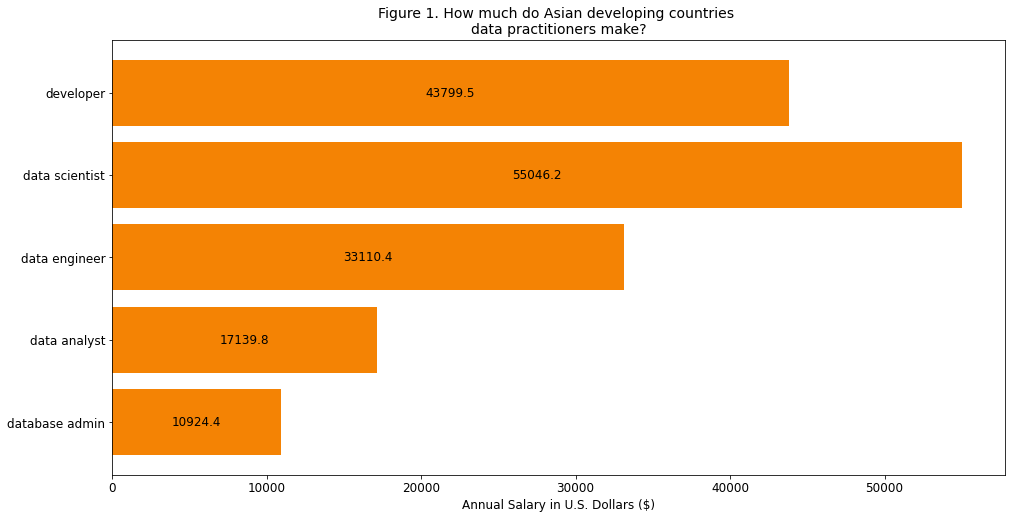

In [76]:
#Developer
df_non_data = all_dev[(all_dev['Dev_Data scientist or machine learning specialist'] != 1) &
           (all_dev['Dev_Engineer, data'] != 1) &
           (all_dev['Dev_Data or business analyst'] != 1) &
           (all_dev['Dev_Database administrator'] != 1)]

#Data Scientist
df_ds = df_encoded[(df_encoded['Dev_Data scientist or machine learning specialist'] == 1) &
           (df_encoded['Dev_Engineer, data'] != 1) &
           (df_encoded['Dev_Data or business analyst'] != 1) &
           (df_encoded['Dev_Database administrator'] != 1) &
           (df_encoded['Dev_Developer, full-stack'] != 1) &
           (df_encoded['Dev_Developer, back-end'] != 1) &
           (df_encoded['Dev_Developer, front-end'] != 1) &
           (df_encoded['Dev_Developer, desktop or enterprise applications'] != 1) &
           (df_encoded['Dev_Developer, mobile'] != 1) &
           (df_encoded['Dev_DevOps specialist'] != 1)]

#Data Engineer
df_deng = df_encoded[(df_encoded['Dev_Data scientist or machine learning specialist'] == 0) &
           (df_encoded['Dev_Engineer, data'] != 0) &
           (df_encoded['Dev_Data or business analyst'] != 1) &
           (df_encoded['Dev_Database administrator'] != 1) &
           (df_encoded['Dev_Developer, full-stack'] != 1) &
           (df_encoded['Dev_Developer, back-end'] != 1) &
           (df_encoded['Dev_Developer, front-end'] != 1) &
           (df_encoded['Dev_Developer, desktop or enterprise applications'] != 1) &
           (df_encoded['Dev_Developer, mobile'] != 1) &
           (df_encoded['Dev_DevOps specialist'] != 1)]

#Data Analyst
df_da = df_encoded[(df_encoded['Dev_Data scientist or machine learning specialist'] == 0) &
           (df_encoded['Dev_Engineer, data'] != 1) &
           (df_encoded['Dev_Data or business analyst'] != 0) &
           (df_encoded['Dev_Database administrator'] != 1) &
           (df_encoded['Dev_Developer, full-stack'] != 1) &
           (df_encoded['Dev_Developer, back-end'] != 1) &
           (df_encoded['Dev_Developer, front-end'] != 1) &
           (df_encoded['Dev_Developer, desktop or enterprise applications'] != 1) &
           (df_encoded['Dev_Developer, mobile'] != 1) &
           (df_encoded['Dev_DevOps specialist'] != 1)]

#Database admin
df_data_admin = df_encoded[(df_encoded['Dev_Data scientist or machine learning specialist'] == 0) &
           (df_encoded['Dev_Engineer, data'] != 1) &
           (df_encoded['Dev_Data or business analyst'] != 1) &
           (df_encoded['Dev_Database administrator'] != 0) &
           (df_encoded['Dev_Developer, full-stack'] != 1) &
           (df_encoded['Dev_Developer, back-end'] != 1) &
           (df_encoded['Dev_Developer, front-end'] != 1) &
           (df_encoded['Dev_Developer, desktop or enterprise applications'] != 1) &
           (df_encoded['Dev_Developer, mobile'] != 1) &
           (df_encoded['Dev_DevOps specialist'] != 1)]

df_roles = pd.DataFrame({'Job Title': ['developer', 
                                       'data scientist', 
                                       'data engineer', 
                                       'data analyst', 
                                       'database admin'],
                         'Salary': [df_non_data['ConvertedCompYearly'].mean(),
                                    df_ds['ConvertedCompYearly'].mean(),
                                    df_deng['ConvertedCompYearly'].mean(),
                                    df_da['ConvertedCompYearly'].mean(),
                                    df_data_admin['ConvertedCompYearly'].mean()]},
                        index=[0,1,2,3,4])

fig, ax = plt.subplots(figsize=(16,8))
ax.barh(df_roles['Job Title'], df_roles['Salary'], color='#f48304')
ax.bar_label(ax.containers[0], fontsize=12, label_type='center')

plt.title('Figure 1. How much do Asian developing countries \ndata practitioners make?', fontsize=14)
plt.xlabel('Annual Salary in U.S. Dollars ($)', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().invert_yaxis()
plt.show()





First we looked at the comparison of salaries data vs non-data job titles as seen in Figure 1. We have observed that data scientist is the highest paying job title at 55,046 followed closely by non-data developers at 43,800. This is in line with our hypothesis that data science is a high paying job given the level of technical proficiency needed for the role. The salary of developers, on the other hand, can be attributed to the steady demand to create different software products. Meanwhile, we can observe data engineers as the 3rd highest role since they are integral in ensuring that the data is accessible for data scientists. At the bottom of the list we have data analysts and database administrators. This shows that not all programming job titles are equal and having the correct one can affect your salary. 

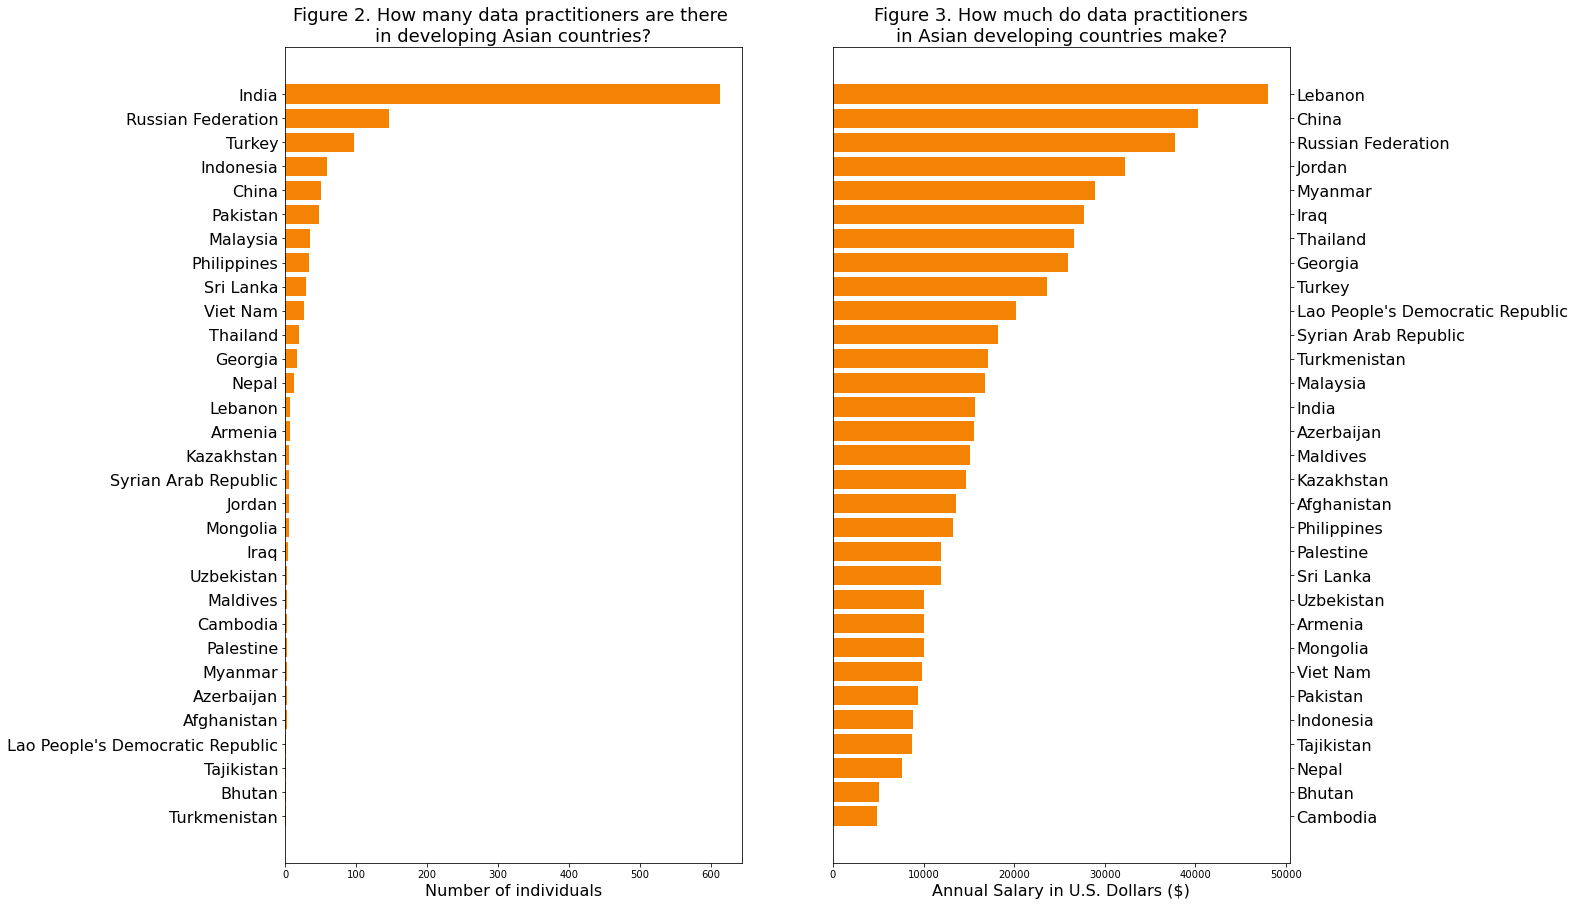

In [77]:
df_country_count = df_encoded.groupby('Country').size().sort_values(ascending=False)
df_country_count
df_country_comp = df_encoded.groupby('Country')['ConvertedCompYearly'].median().sort_values(ascending=False)
df_country_comp

fig, ax = plt.subplots(figsize=(18,15), ncols=2)
ax[0].barh(df_country_count.index, df_country_count.values, color='#f48304')
ax[0].invert_yaxis()
ax[0].set_title('Figure 2. How many data practitioners are there \nin developing Asian countries?', 
                fontsize=18)
ax[0].set_xlabel('Number of individuals', fontsize=16)
ax[0].tick_params(axis="y", labelsize=16) 


ax[1].barh(df_country_comp.index, df_country_comp.values, color='#f48304')
ax[1].invert_yaxis()
ax[1].set_title('Figure 3. How much do data practitioners\nin Asian developing countries make?', 
                fontsize=18)
ax[1].set_xlabel('Annual Salary in U.S. Dollars ($)', fontsize=16)
ax[1].yaxis.tick_right()
ax[1].tick_params(axis="y", labelsize=16) 

plt.show()

Next here we have an analysis of data practitioners in countries in developing Asia as seen in Figure 2 and 3. India, by far, has the most number of programmers encompassing more than half of the asian developing countries programmers data. India is followed by the Russian Federation then by Turkey. However, despite having the most number of data practitioners, India is only 14th in terms of average salary. In comparison, Russia is still one of the top at the 3rd spot overtaken only by China and Lebanon. By looking at these two graphs, we can see that a country that has provided many opportunities to data practitioners does not necessarily also offer the highest pay. 

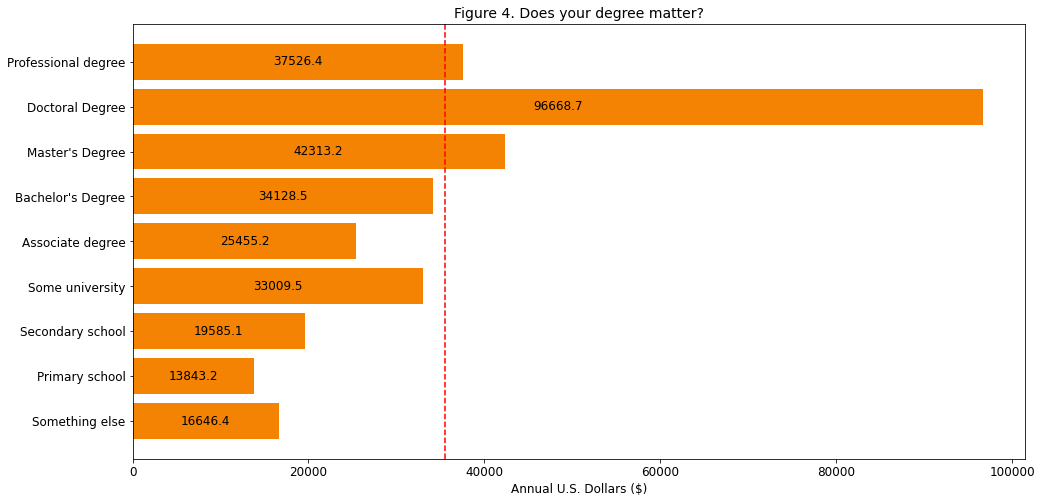

In [78]:
df_ed = df_encoded.groupby('EdLevel')['ConvertedCompYearly'].mean().reset_index()
df_ed = df_ed.replace([0,1,2,3,4,5,6,7,8], 
                      ["Something else", 'Primary school', "Secondary school", 
                       "Some university", "Associate degree","Bachelor's Degree", 
                       "Master's Degree", "Doctoral Degree", "Professional degree"])
# df_ed = df_ed[df_ed['EdLevel'].isin(["Bachelor's Degree", "Master's Degree", "Ph.D."])]

fig, ax = plt.subplots(figsize=(16,8))
ax.barh(df_ed['EdLevel'],
        df_ed['ConvertedCompYearly'],
        color='#f48304')
ax.axline([np.mean(df_ed['ConvertedCompYearly']), 0], 
          [np.mean(df_ed['ConvertedCompYearly']), 1], color='r', linestyle='--')
ax.bar_label(ax.containers[0], fontsize=12, label_type='center')
plt.title('Figure 4. Does your degree matter?', fontsize=14)
plt.xlabel('Annual U.S. Dollars ($)', fontsize=12, rotation=0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

We then analyzed the educational background among data practitioners as seen in figure 4 and saw that having a doctoral degree increases your salary more than the average. Having a Master’s degree though should not be overlooked since it also provides a salary higher than the average. The rest follows an intuitive trend wherein having any form of university degree provides better salary than being only a primary or secondary level graduate.

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


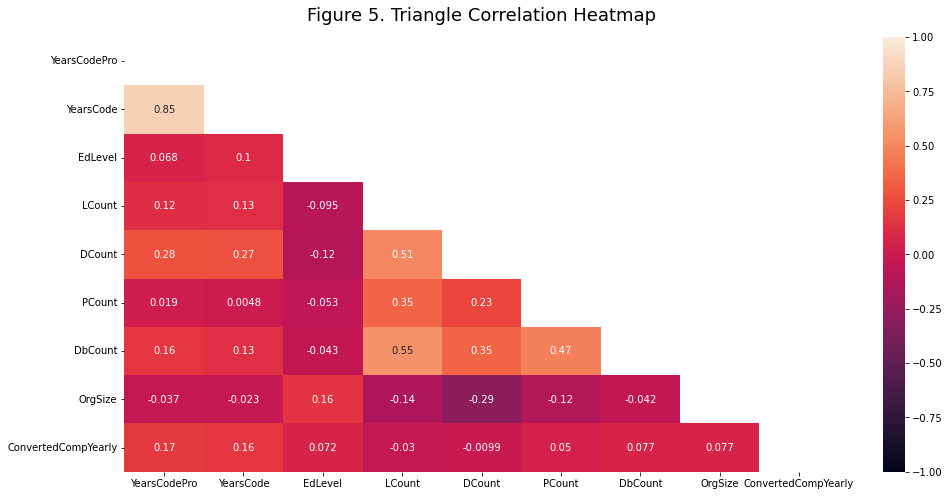

In [79]:
df_cont = df_encoded[['YearsCodePro','YearsCode', 'EdLevel',
                    'LCount','DCount','PCount','DbCount', 'OrgSize',
                    'ConvertedCompYearly']]
def get_tri_corr_matrix(df_eda, figsize):
    
    plt.figure(figsize=figsize)
    # define the mask to set the values in the upper triangle to True

    mask = np.triu(np.ones_like(df_eda.corr(), dtype=np.bool))
    heatmap = sns.heatmap(df_eda.corr(), mask=mask, vmin=-1, vmax=1, annot=True)
    heatmap.set_title('Figure 5. Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

get_tri_corr_matrix(df_cont, (16,8))

Lastly, we look at the correlation among select features that can affect salary as seen in figure 5. We observed that years coding and years coding professionally have the highest correlation among the selected features albeit still low at only 0.17. All the rest have less than 0.1 correlation to salary. As expected, years coding and years coding professionally has a strong correlation at 0.85 while the count of languages (LCount), platforms (PCount), databases (DbCount), and job titles (DCount), all have a mild to moderate correlation with each other. We will verify later on if these correlations follow our model results. 


## III. Model Preparation

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


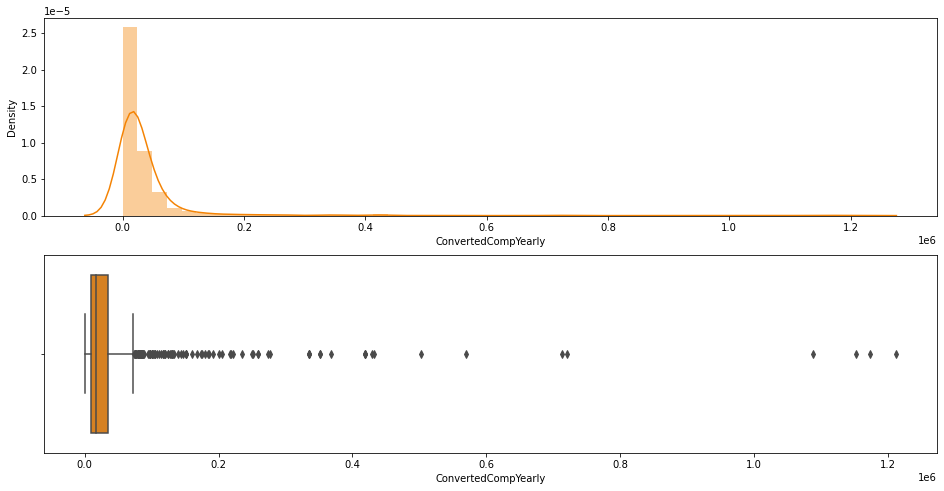

In [80]:
fig, ax = plt.subplots(figsize=(16,8), nrows=2)
sns.distplot(df_encoded['ConvertedCompYearly'], ax=ax[0], color='#f48304')
sns.boxplot(df_encoded['ConvertedCompYearly'], orient='h', ax=ax[1], color='#f48304')
plt.show()

### III.A. Removing Outliers

As can be seen in the EDA plots above, there are outliers present in the target variable. These outliers will cause the models to perform badly. With this, these outliers need to be removed. As suggested by our mentor, sklearn's `IsolationForest` was the model used to remove these outliers. A total of 148 data points were flagged as anomalous/outlying and therefore dropped.

In [81]:
from sklearn.ensemble import IsolationForest
isoforest = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.12 , max_features=1, random_state=11)
isoforest.fit(df_encoded[['ConvertedCompYearly']])

df_encoded['scores']=isoforest.decision_function(df_encoded[['ConvertedCompYearly']])
df_encoded['anomaly']=isoforest.predict(df_encoded[['ConvertedCompYearly']])

X does not have valid feature names, but IsolationForest was fitted with feature names
X does not have valid feature names, but IsolationForest was fitted with feature names


In [82]:
outliers_iso = df_encoded[df_encoded['anomaly']==-1].index
print('number of outliers: ', len(outliers_iso), '\n shape of df_final with outliers: ', df_encoded.shape)
df_encoded.drop(outliers_iso, axis=0, inplace=True)

number of outliers:  148 
 shape of df_final with outliers:  (1247, 148)


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


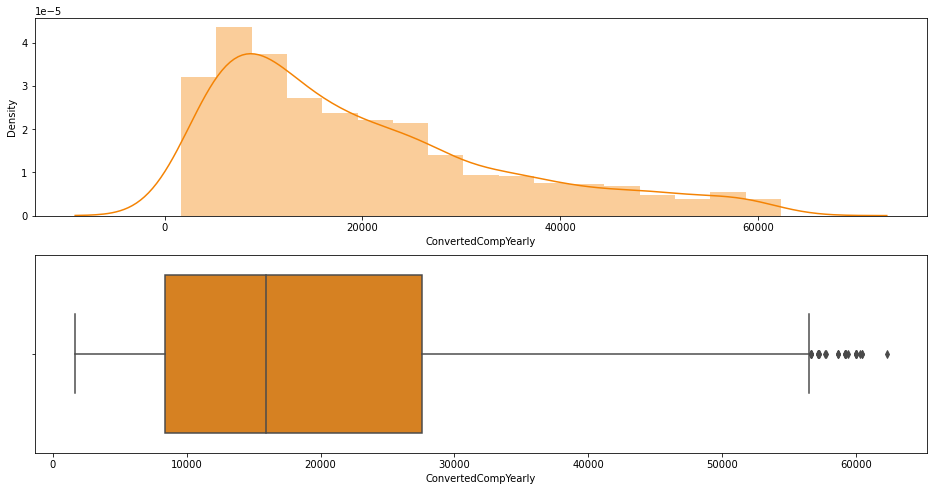

In [83]:
fig, ax = plt.subplots(figsize=(16,8), nrows=2)
sns.distplot(df_encoded['ConvertedCompYearly'], ax=ax[0], color='#f48304')
sns.boxplot(df_encoded['ConvertedCompYearly'], orient='h', ax=ax[1], color='#f48304')
plt.show()

In [84]:
df_encoded.drop(columns=['scores', 'anomaly'], inplace=True)

### III.B. Dropping countries that have < 5 rows

Another observation after previous iterations, was that data points that belonged to a rare country needed to be dropped if the total number of data points were less than 5. This is because sklearns `StratefiedKFold` function with 5 splits, required at least 5 data points for a certain country in order to do the stratification on the `Country` column. To be able to do the folds with 5 splits, dropping of these data points was done. A total of 22 rows were dropped.  

In [86]:
df_encoded.drop(drop_list, inplace=True)
df_encoded

,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",...,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2,LCount,DCount,PCount,DbCount,Country
29,1,6,20.0,16.0,2,5.0,37752,1,0,0,...,0,0,0,0,0,3,4,1,1,Russian Federation
58,0,8,5.0,3.0,4,1.0,22644,1,0,0,...,0,0,0,0,0,5,2,1,1,Russian Federation
148,0,6,2.0,2.0,1,5.0,36000,0,0,1,...,0,0,0,0,0,1,2,1,1,Sri Lanka
154,1,5,20.0,7.0,1,4.0,2340,0,0,1,...,0,0,0,0,0,7,8,1,5,India
168,1,3,4.0,2.0,1,4.0,14844,0,0,1,...,0,0,0,0,0,4,4,2,1,Georgia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83046,0,6,14.0,11.0,4,4.0,13962,1,0,0,...,0,0,0,0,0,5,7,2,4,India
83291,1,5,5.0,2.0,9,3.0,5026,1,0,0,...,0,0,0,0,0,6,3,1,4,India
83294,1,3,15.0,13.0,4,0.0,30192,1,0,0,...,0,0,0,0,0,2,4,1,4,Russian Federation
83356,1,5,11.0,5.0,1,0.0,7020,0,0,1,...,0,0,0,0,0,18,16,6,7,Indonesia


# IV. ML

Once the data is finally prepared and ready, a set of regression models were chosen to be train and tested. Models such as `XGBoost`, `Random Forest`, `Gradient Boosting Method`, `KNN`, and `Multi Layer Perceptron` was used. 

In [87]:
X = df_encoded[df_encoded.columns.difference(['ConvertedCompYearly'])]
y = df_encoded['ConvertedCompYearly']

X_xgb = X
y_xgb = y

## IV. A. Splitting the data

Prior to model fitting and testing, a proper splitting of train and test sets is done. The 75-25 train-test splitting is stratified according to the country as mentioned in the previous sections. 

After splitting the models are then train, evaluated, and tested. The optimal hyperparameters are obtained using cross-validation (CV). For this project, the hyperparameter tuning framework used for CV is optuna's framework. 

It is also important to note that scaling of the features were also included in the pipeline as it was deemed necessary to do based from previous iterations. This was necessary especially for the target variable which is the annual compensation of the participants as previous iterations without scaling resulted in a high MAE. A `MinMaxScaler()` was applied on the target variable on a per country basis and not the whole data set.

The following sections are the training, evaluation, and testing of the mentioned models. The average validation score, optimal parameters, and average test scores are displayed in that order. 

In [88]:
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                           random_state=11, test_size=0.25, stratify=X['Country'])

## IV.B. Model Iterations

### IV.B.1. XGBoost

In [48]:
def tune_XGBoost(X, y):
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import cross_validate
    
    def optimize(trial):
        # Definition of space search
        param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0, step=0.1),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0, step=0.1),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 10, 500, step=10),
        'max_depth': trial.suggest_int('max_depth', 2,15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        }
        
        # Classifier definition
        model = xgb.XGBRegressor(seed=20, **param)

        scaler = MinMaxScaler()
        
        pipe = Pipeline(steps = [['scale', scaler],['xgb', model]]) #on
        
#         cr_val = cross_val_score(rf_pipe, X, y, cv=5, scoring=make_scorer(mean_absolute_error)) #on
        
        skf = StratifiedKFold(n_splits=4)
        mae_list=[]
        for train_idx, val_idx in skf.split(X, X['Country']):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]

            ### Fitting scalers per country
            def get_country_index(X, country):
                return X[X[f'Country_{country}']==1].index

            country_list = X['Country'].unique().tolist()
            country_index_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
                country_index_dict[c] = [get_country_index(X_train, c), scaler]

            #### scaling train sets
            # y
            ytrain_scaled_dict = {}
            for key, val in country_index_dict.items():
                y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
                ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

            y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

            # X 
            X_train_final = X_train.drop(columns=['Country'], axis=0)

            y_train_final.name = 'y'
            y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


            #### scaling val sets
            # y

            country_index_val_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
                country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


            yval_scaled_dict = {}
            for key, val in country_index_val_dict.items():
                y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
                yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

            y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

            # X
            X_val_final = X_val.drop(columns=['Country'], axis=0)


            y_val_final.name = 'y'
            y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']

            scaler = MinMaxScaler()
            X_train_feed = scaler.fit_transform(X_train_final)
            X_val_feed = scaler.transform(X_val_final)

            model.fit(X_train_feed, y_train_final)

            y_pred = model.predict(X_val_feed)

        #     ### Inverse scaling before calculating MAE
            y_pred_dict = {}
            for key, val in country_index_val_dict.items():
                val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
                y_country = y_pred[val_indices]
                # inverse minmax scaling....
                y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
                y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


            y_val_dict = {}
            for key, val in y_pred_dict.items():
                y_val_country = y_val_final.reset_index(drop=True)[val[0]]
                y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
                y_val_dict[key] = y_val_country_inversed_scaled.ravel()

            y_val_sorted = [list(elem) for elem in y_val_dict.values()]
            y_val_mae = []
            for elem in y_val_sorted:
                y_val_mae = y_val_mae + elem

            y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
            y_pred_mae = []
            for elem in y_pred_sorted:
                y_pred_mae = y_pred_mae + elem


            mae = mean_absolute_error(y_val_mae, y_pred_mae)
            mae_list.append(mae)
        
        
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=200, n_jobs=4)
    return study, optimize

### CV

In [49]:
xgb_study, xgb_optimize = tune_XGBoost(X_trainval, y_trainval)

[I 2021-12-02 20:41:18,039] A new study created in memory with name: no-name-090b8e81-1342-4840-89b4-94d2f5c48454
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2021-12-02 20:41:20,579] Trial 1 finished with value: 10591.503781383633 and parameters: {'lambda': 3.967863483557992, 'alpha': 0.2654192000874032, 'colsample_bytree': 0.9000000000000001, 'subsample': 0.5, 'learning_rate': 0.7466308663149559, 'n_estimators': 130, 'max_depth': 13, 'min_child_weight': 198}. Best is trial 1 with value: 10591.503781383633.
[I 2021-12-02 20:41:23,698] Trial 3 finished with value: 8708.998107662119 and parameters: {'lambda': 0.01887248952661114, 'alpha': 0.5336643240525143, 'colsample_bytree': 0.8, 'subsample': 0.9000000000000001, 'learning_rate': 0.03385469711514547, 'n_estimators': 340, 'max_depth': 12, 'min_child_weight': 259}. Best is trial 3 with value: 8708.998107662119.
[I 2021-12-02 20:41:23

In [50]:
xgb_study.best_value

8023.153009851274

In [51]:
xgb_study.best_params

{'lambda': 0.001228727936529487,
 'alpha': 0.01002738325350634,
 'colsample_bytree': 1.0,
 'subsample': 0.8,
 'learning_rate': 0.01986165969236614,
 'n_estimators': 470,
 'max_depth': 15,
 'min_child_weight': 79}

In [89]:
def testing_optimal_model(model, n_trials):

    mae_list=[]
    mape_list=[]
    rmse_list=[]
    r2_list=[]
    for n in tqdm_notebook(range(n_trials)):
        (X_train, X_val, y_train, y_val) = train_test_split(X, y,
                                                              random_state=n, 
                                                              test_size=0.25, stratify=X['Country'])

        ### Fitting scalers per country
        def get_country_index(X, country):
            return X[X[f'Country_{country}']==1].index

        country_list = X['Country'].unique().tolist()
        country_index_dict = {}
        for c in country_list:
            scaler = MinMaxScaler()
            scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
            country_index_dict[c] = [get_country_index(X_train, c), scaler]

        #### scaling train sets
        # y
        ytrain_scaled_dict = {}
        for key, val in country_index_dict.items():
            y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
            ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

        y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

        # X 
        X_train_final = X_train.drop(columns=['Country'], axis=0)

        y_train_final.name = 'y'
        y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


        #### scaling val sets
        # y

        country_index_val_dict = {}
        for c in country_list:
            scaler = MinMaxScaler()
            scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
            country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


        yval_scaled_dict = {}
        for key, val in country_index_val_dict.items():
            y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
            yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

        y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

        # X
        X_val_final = X_val.drop(columns=['Country'], axis=0)


        y_val_final.name = 'y'
        y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']



        scaler = MinMaxScaler()
        X_train_feed = scaler.fit_transform(X_train_final)
        X_val_feed = scaler.transform(X_val_final)

        model.fit(X_train_feed, y_train_final)

        y_pred = model.predict(X_val_feed)

    #     ### Inverse scaling before calculating MAE
        y_pred_dict = {}
        for key, val in country_index_val_dict.items():
            val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
            y_country = y_pred[val_indices]
            # inverse minmax scaling....
            y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
            y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


        y_val_dict = {}
        for key, val in y_pred_dict.items():
            y_val_country = y_val_final.reset_index(drop=True)[val[0]]
            y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
            y_val_dict[key] = y_val_country_inversed_scaled.ravel()

        y_val_sorted = [list(elem) for elem in y_val_dict.values()]
        y_val_mae = []
        for elem in y_val_sorted:
            y_val_mae = y_val_mae + elem

        y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
        y_pred_mae = []
        for elem in y_pred_sorted:
            y_pred_mae = y_pred_mae + elem


        mae = mean_absolute_error(y_val_mae, y_pred_mae)
        r2 = r2_score(y_val_mae, y_pred_mae)
        mape = mean_absolute_percentage_error(y_val_mae, y_pred_mae)
        rmse = np.sqrt(mean_squared_error(y_val_mae, y_pred_mae))
        
        mae_list.append(mae)
        mape_list.append(mape)
        rmse_list.append(rmse)
        r2_list.append(r2)
    return np.mean(mae_list), np.mean(mape_list), np.mean(rmse_list), np.mean(r2_list), mae_list

In [90]:
# {'lambda': 2.6023460786610775,
#  'alpha': 0.031034911484978875,
#  'colsample_bytree': 0.9000000000000001,
#  'subsample': 0.5,
#  'learning_rate': 0.035172129329832345,
#  'n_estimators': 350,
#  'max_depth': 2,
#  'min_child_weight': 11}

# xgbr = xgb.XGBRegressor(seed=20, **xgb_study.best_params)
xgbr = xgb.XGBRegressor(seed=20, **{'lambda': 2.6023460786610775,
                                  'alpha': 0.031034911484978875,
                                  'colsample_bytree': 0.9000000000000001,
                                  'subsample': 0.5,
                                  'learning_rate': 0.035172129329832345,
                                  'n_estimators': 350,
                                  'max_depth': 2,
                                  'min_child_weight': 11})
xgb_mae, xgb_mape, xgb_rmse, xgb_r2, xgb_mae_list = testing_optimal_model(xgbr, 20)
xgb_mae

  0%|          | 0/20 [00:00<?, ?it/s]

8165.732085356535

### IV.B.2 Random Forest

For models other than `XGBoost` rows that have null values on the `SOPartFreq` column will be dropped since sklearn's implementations of these models can not handle missing values unlike that of `XGBoost`. This results in a reduced dataset with no null values. A second similar splitting is performed on the new dataset. 

In [54]:
df_encoded.dropna(inplace=True)
drop_list = []
for country in df_encoded['Country'].unique():
    df = df_encoded[df_encoded['Country']==country]
    if len(df) < 5:
        for elem in df.index:
            drop_list.append(elem)
display(len(drop_list))
df_encoded.drop(drop_list, inplace=True)
X = df_encoded[df_encoded.columns.difference(['ConvertedCompYearly'])]
y = df_encoded['ConvertedCompYearly']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                           random_state=11, test_size=0.25, stratify=X['Country'])

8

In [55]:
def tune_RF(X, y):
    # from optuna.samplers import RandomSampler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import KFold
    
    def optimize(trial):
        # Definition of space search
        n_estimators = trial.suggest_int('n_estimators', 10,500, step=10)
        max_depth = trial.suggest_int('max_depth', 2,100)
        # max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        max_features = trial.suggest_int('max_features', 2, X.shape[1]-1)
        
        # Classifier definition
        model = RandomForestRegressor(n_estimators=n_estimators,
                                       max_depth=max_depth,
                                       max_features=max_features, random_state=11)
        scaler = MinMaxScaler()
        
        rf_pipe = Pipeline(steps = [['scale', scaler],['rf', model]]) #on
        
#         cr_val = cross_val_score(rf_pipe, X, y, cv=5, scoring=make_scorer(mean_absolute_error)) #on
        
        skf = StratifiedKFold(n_splits=4)
        mae_list=[]
        for train_idx, val_idx in skf.split(X, X['Country']):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]

            ### Fitting scalers per country
            def get_country_index(X, country):
                return X[X[f'Country_{country}']==1].index

            country_list = X['Country'].unique().tolist()
            country_index_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
                country_index_dict[c] = [get_country_index(X_train, c), scaler]

            #### scaling train sets
            # y
            ytrain_scaled_dict = {}
            for key, val in country_index_dict.items():
                y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
                ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

            y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

            # X 
            X_train_final = X_train.drop(columns=['Country'], axis=0)

            y_train_final.name = 'y'
            y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


            #### scaling val sets
            # y

            country_index_val_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
                country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


            yval_scaled_dict = {}
            for key, val in country_index_val_dict.items():
                y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
                yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

            y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

            # X
            X_val_final = X_val.drop(columns=['Country'], axis=0)


            y_val_final.name = 'y'
            y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']

            scaler = MinMaxScaler()
            X_train_feed = scaler.fit_transform(X_train_final)
            X_val_feed = scaler.transform(X_val_final)

            model.fit(X_train_feed, y_train_final)

            y_pred = model.predict(X_val_feed)

        #     ### Inverse scaling before calculating MAE
            y_pred_dict = {}
            for key, val in country_index_val_dict.items():
                val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
                y_country = y_pred[val_indices]
                # inverse minmax scaling....
                y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
                y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


            y_val_dict = {}
            for key, val in y_pred_dict.items():
                y_val_country = y_val_final.reset_index(drop=True)[val[0]]
                y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
                y_val_dict[key] = y_val_country_inversed_scaled.ravel()

            y_val_sorted = [list(elem) for elem in y_val_dict.values()]
            y_val_mae = []
            for elem in y_val_sorted:
                y_val_mae = y_val_mae + elem

            y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
            y_pred_mae = []
            for elem in y_pred_sorted:
                y_pred_mae = y_pred_mae + elem


            mae = mean_absolute_error(y_val_mae, y_pred_mae)
            mae_list.append(mae)
        
        
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=200, n_jobs=4)
    return study, optimize

### CV

In [56]:
rf_study, rf_optimize = tune_RF(X_trainval, y_trainval)

[I 2021-12-02 20:47:48,927] A new study created in memory with name: no-name-e994670e-cd35-4715-8d56-020b0a0419fa
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2021-12-02 20:47:51,068] Trial 2 finished with value: 8634.019733632176 and parameters: {'n_estimators': 20, 'max_depth': 63, 'max_features': 79}. Best is trial 2 with value: 8634.019733632176.
[I 2021-12-02 20:47:53,193] Trial 4 finished with value: 8760.617126645397 and parameters: {'n_estimators': 50, 'max_depth': 65, 'max_features': 48}. Best is trial 2 with value: 8634.019733632176.
[I 2021-12-02 20:47:55,485] Trial 5 finished with value: 8709.372152532835 and parameters: {'n_estimators': 40, 'max_depth': 71, 'max_features': 74}. Best is trial 2 with value: 8634.019733632176.
[I 2021-12-02 20:47:58,993] Trial 0 finished with value: 8839.918850585316 and parameters: {'n_estimators': 500, 'max_depth': 41, 'max_features': 6}

In [57]:
rf_study.best_value

8572.998632330506

In [58]:
rf_study.best_params

{'n_estimators': 120, 'max_depth': 97, 'max_features': 51}

In [59]:
rf = RandomForestRegressor(**rf_study.best_params, random_state=11)
rf_mae, rf_mape, rf_rmse, rf_r2, rf_mae_list = testing_optimal_model(rf, 20)
rf_mae

  0%|          | 0/20 [00:00<?, ?it/s]

8624.500599799481

### IV.B.3. Gradient Boosting Method

In [60]:
def tune_GBM_2(X, y):
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import cross_validate
    
    def optimize(trial):
        # Definition of space search
        n_estimators = trial.suggest_int('n_estimators', 10,800, step=10)
        max_depth = trial.suggest_int('max_depth', 2,100)
        # max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
        max_features = trial.suggest_int('max_features', 2, X.shape[1]-1)
        learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-1)
        
        # Classifier definition
        model = GradientBoostingRegressor(n_estimators=n_estimators,
                                           max_depth=max_depth,
                                           max_features=max_features,
                                           learning_rate=learning_rate, random_state=11)

        scaler = MinMaxScaler()
        
        pipe = Pipeline(steps = [['scale', scaler],['gbm', model]]) #on
        
#         cr_val = cross_val_score(rf_pipe, X, y, cv=5, scoring=make_scorer(mean_absolute_error)) #on
        
        skf = StratifiedKFold(n_splits=4)
        mae_list=[]
        for train_idx, val_idx in skf.split(X, X['Country']):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]

            ### Fitting scalers per country
            def get_country_index(X, country):
                return X[X[f'Country_{country}']==1].index

            country_list = X['Country'].unique().tolist()
            country_index_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
                country_index_dict[c] = [get_country_index(X_train, c), scaler]

            #### scaling train sets
            # y
            ytrain_scaled_dict = {}
            for key, val in country_index_dict.items():
                y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
                ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

            y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

            # X 
            X_train_final = X_train.drop(columns=['Country'], axis=0)

            y_train_final.name = 'y'
            y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


            #### scaling val sets
            # y

            country_index_val_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
                country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


            yval_scaled_dict = {}
            for key, val in country_index_val_dict.items():
                y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
                yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

            y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

            # X
            X_val_final = X_val.drop(columns=['Country'], axis=0)


            y_val_final.name = 'y'
            y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']



            scaler = MinMaxScaler()
            X_train_feed = scaler.fit_transform(X_train_final)
            X_val_feed = scaler.transform(X_val_final)

            model.fit(X_train_feed, y_train_final)

            y_pred = model.predict(X_val_feed)

        #     ### Inverse scaling before calculating MAE
            y_pred_dict = {}
            for key, val in country_index_val_dict.items():
                val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
                y_country = y_pred[val_indices]
                # inverse minmax scaling....
                y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
                y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


            y_val_dict = {}
            for key, val in y_pred_dict.items():
                y_val_country = y_val_final.reset_index(drop=True)[val[0]]
                y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
                y_val_dict[key] = y_val_country_inversed_scaled.ravel()

            y_val_sorted = [list(elem) for elem in y_val_dict.values()]
            y_val_mae = []
            for elem in y_val_sorted:
                y_val_mae = y_val_mae + elem

            y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
            y_pred_mae = []
            for elem in y_pred_sorted:
                y_pred_mae = y_pred_mae + elem

            
            mae = mean_absolute_error(y_val_mae, y_pred_mae)
            mae_list.append(mae)
        
    
    
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=200, n_jobs=4)
    return study, optimize

### CV

In [61]:
gbm_study_2, gbm_optimize_2 = tune_GBM_2(X_trainval ,y_trainval)

[I 2021-12-02 20:54:26,374] A new study created in memory with name: no-name-1318b7cb-399d-483a-8ea7-3f10d9aaecf3
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2021-12-02 20:54:31,731] Trial 2 finished with value: 9070.154049649456 and parameters: {'n_estimators': 410, 'max_depth': 69, 'max_features': 65, 'learning_rate': 0.09546668842790389}. Best is trial 2 with value: 9070.154049649456.
[I 2021-12-02 20:54:33,533] Trial 3 finished with value: 9195.58238926969 and parameters: {'n_estimators': 160, 'max_depth': 17, 'max_features': 106, 'learning_rate': 0.04473718004336157}. Best is trial 2 with value: 9070.154049649456.
[I 2021-12-02 20:54:34,972] Trial 0 finished with value: 9691.698360851626 and parameters: {'n_estimators': 620, 'max_depth': 67, 'max_features': 124, 'learning_rate': 0.09346250087212826}. Best is trial 2 with value: 9070.154049649456.
[I 2021-12-02 20:54:36,567] Tr

In [62]:
gbm_study_2.best_params

{'n_estimators': 510,
 'max_depth': 2,
 'max_features': 15,
 'learning_rate': 0.05736266924848544}

In [63]:
gbm_study_2.best_value

8192.438029231931

In [64]:
gbm_2 = GradientBoostingRegressor(**gbm_study_2.best_params, random_state=11)
gbm_mae, gbm_mape, gbm_rmse, gbm_r2, gbm_mae_list = testing_optimal_model(gbm_2, 20)
gbm_mae

  0%|          | 0/20 [00:00<?, ?it/s]

8272.64538547835

### IV.B.4. KNN

In [65]:
def tune_KNN(X, y):
    
    def optimize(trial):
        # Definition of space search
        n_neighbors = trial.suggest_int('n_neighbors', 2, 300, step=10)
        
        
        # Classifier definition
        model = KNeighborsRegressor(n_neighbors=n_neighbors)

        
        skf = StratifiedKFold(n_splits=4)
        mae_list=[]
        for train_idx, val_idx in skf.split(X, X['Country']):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]

            ### Fitting scalers per country
            def get_country_index(X, country):
                return X[X[f'Country_{country}']==1].index

            country_list = X['Country'].unique().tolist()
            country_index_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
                country_index_dict[c] = [get_country_index(X_train, c), scaler]

            #### scaling train sets
            # y
            ytrain_scaled_dict = {}
            for key, val in country_index_dict.items():
                y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
                ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

            y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

            # X 
            X_train_final = X_train.drop(columns=['Country'], axis=0)

            y_train_final.name = 'y'
            y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


            #### scaling val sets
            # y

            country_index_val_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
                country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


            yval_scaled_dict = {}
            for key, val in country_index_val_dict.items():
                y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
                yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

            y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

            # X
            X_val_final = X_val.drop(columns=['Country'], axis=0)


            y_val_final.name = 'y'
            y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']



            scaler = MinMaxScaler()
            X_train_feed = scaler.fit_transform(X_train_final)
            X_val_feed = scaler.transform(X_val_final)

            model.fit(X_train_feed, y_train_final)

            y_pred = model.predict(X_val_feed)

        #     ### Inverse scaling before calculating MAE
            y_pred_dict = {}
            for key, val in country_index_val_dict.items():
                val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
                y_country = y_pred[val_indices]
                # inverse minmax scaling....
                y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
                y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


            y_val_dict = {}
            for key, val in y_pred_dict.items():
                y_val_country = y_val_final.reset_index(drop=True)[val[0]]
                y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
                y_val_dict[key] = y_val_country_inversed_scaled.ravel()

            y_val_sorted = [list(elem) for elem in y_val_dict.values()]
            y_val_mae = []
            for elem in y_val_sorted:
                y_val_mae = y_val_mae + elem

            y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
            y_pred_mae = []
            for elem in y_pred_sorted:
                y_pred_mae = y_pred_mae + elem

            
            mae = mean_absolute_error(y_val_mae, y_pred_mae)
            mae_list.append(mae)
        
    
    
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=200, n_jobs=4)
    return study, optimize

### CV

In [66]:
knn_study, knn_optimize = tune_KNN(X_trainval ,y_trainval)

[I 2021-12-02 20:59:30,203] A new study created in memory with name: no-name-e387fee4-44c1-46af-a455-ac7fb407e511
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
The distribution is specified by [2, 300] and step=10, but the range is not divisible by `step`. It will be replaced by [2, 292].
[I 2021-12-02 20:59:32,513] Trial 2 finished with value: 9906.91894980093 and parameters: {'n_neighbors': 202}. Best is trial 2 with value: 9906.91894980093.
The distribution is specified by [2, 300] and step=10, but th

In [67]:
knn_study.best_params

{'n_neighbors': 12}

In [68]:
knn_study.best_value

9150.40264734625

In [69]:
knn = KNeighborsRegressor(**knn_study.best_params)
knn_mae, knn_mape, knn_rmse, knn_r2, knn_mae_list = testing_optimal_model(knn, 20)
knn_mae

  0%|          | 0/20 [00:00<?, ?it/s]

9398.783208644807

### IV.B.5. MLP

In [70]:
def tune_MLP(X, y):

    from sklearn.model_selection import cross_validate
    
    def optimize(trial):
        # Definition of space search
        n_layers = trial.suggest_int('n_layers', 1, 4)
        layers = []
        for i in range(n_layers):
            layers.append(trial.suggest_int(f'n_units_{i}', 1, 100))
        
        
        activations = trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic'])
        alpha = trial.suggest_float('alpha', 1e-4, 0.6)
        solver = trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam'])
        learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive'])
        
        # Classifier definition
        model = MLPRegressor(hidden_layer_sizes=tuple(layers),
                             activation=activations,
                             alpha=alpha,
                             learning_rate=learning_rate,
                             solver=solver, 
                             random_state=11, 
                             max_iter=1_000_000)

        scaler = MinMaxScaler()
        
        
#         cr_val = cross_val_score(rf_pipe, X, y, cv=5, scoring=make_scorer(mean_absolute_error)) #on
        
        skf = StratifiedKFold(n_splits=4)
        mae_list=[]
        for train_idx, val_idx in skf.split(X, X['Country']):
            X_train, y_train = X.iloc[train_idx,:], y.iloc[train_idx]
            X_val, y_val = X.iloc[val_idx,:], y.iloc[val_idx]

            ### Fitting scalers per country
            def get_country_index(X, country):
                return X[X[f'Country_{country}']==1].index

            country_list = X['Country'].unique().tolist()
            country_index_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
                country_index_dict[c] = [get_country_index(X_train, c), scaler]

            #### scaling train sets
            # y
            ytrain_scaled_dict = {}
            for key, val in country_index_dict.items():
                y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
                ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

            y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

            # X 
            X_train_final = X_train.drop(columns=['Country'], axis=0)

            y_train_final.name = 'y'
            y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


            #### scaling val sets
            # y

            country_index_val_dict = {}
            for c in country_list:
                scaler = MinMaxScaler()
                scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
                country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


            yval_scaled_dict = {}
            for key, val in country_index_val_dict.items():
                y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
                yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

            y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

            # X
            X_val_final = X_val.drop(columns=['Country'], axis=0)


            y_val_final.name = 'y'
            y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']



            scaler = MinMaxScaler()
            X_train_feed = scaler.fit_transform(X_train_final)
            X_val_feed = scaler.transform(X_val_final)

            model.fit(X_train_feed, y_train_final)

            y_pred = model.predict(X_val_feed)

        #     ### Inverse scaling before calculating MAE
            y_pred_dict = {}
            for key, val in country_index_val_dict.items():
                val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
                y_country = y_pred[val_indices]
                # inverse minmax scaling....
                y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
                y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


            y_val_dict = {}
            for key, val in y_pred_dict.items():
                y_val_country = y_val_final.reset_index(drop=True)[val[0]]
                y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
                y_val_dict[key] = y_val_country_inversed_scaled.ravel()

            y_val_sorted = [list(elem) for elem in y_val_dict.values()]
            y_val_mae = []
            for elem in y_val_sorted:
                y_val_mae = y_val_mae + elem

            y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
            y_pred_mae = []
            for elem in y_pred_sorted:
                y_pred_mae = y_pred_mae + elem

            
            mae = mean_absolute_error(y_val_mae, y_pred_mae)
            mae_list.append(mae)
        
    
    
        # return np.mean(cr_val) #on
        return np.mean(mae_list)
    
    study = optuna.create_study(direction='minimize')
    study.optimize(optimize, n_trials=100, n_jobs=4)
    return study, optimize

### CV

In [71]:
MLP_study, MLP_optimize = tune_MLP(X_trainval , y_trainval)

[I 2021-12-02 21:01:50,530] A new study created in memory with name: no-name-55f35d8c-e828-4667-97c5-0ca2887b76b0
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
[I 2021-12-02 21:01:54,749] Trial 0 finished with value: 10949.930827212718 and parameters: {'n_layers': 3, 'n_units_0': 100, 'n_units_1': 35, 'n_units_2': 78, 'activation': 'relu', 'alpha': 0.4296008623768964, 'solver': 'sgd', 'learning_rate': 'invscaling'}. Best is trial 0 with value: 10949.930827212718.
[I 2021-12-02 21:01:55,407] Trial 1 finished with value: 15479.406449319304 and parameters: {'n_layers': 2, 'n_units_0': 45, 'n_units_1': 62, 'activation': 'tanh', 'alpha': 0.25608498741828656, 'solver': 'sgd', 'learning_rate': 'invscaling'}. Best is trial 0 with value: 10949.930827212718.
[I 2021-12-02 21:02:03,722] Trial 2 finished with value: 11505.798881012113 and parameters: {'n_layers': 1, 'n_units_0': 16, 'activation': '

In [72]:
MLP_study.best_params

{'n_layers': 3,
 'n_units_0': 2,
 'n_units_1': 58,
 'n_units_2': 50,
 'activation': 'tanh',
 'alpha': 0.41752566746433967,
 'solver': 'adam',
 'learning_rate': 'adaptive'}

In [73]:
MLP_study.best_value

8378.338362886758

In [74]:
tup=[]
study = MLP_study.best_params
for layer in range(study['n_layers']):
    tup.append(study[f'n_units_{layer}'])
    del study[f'n_units_{layer}']
del study['n_layers']
tup = tuple(tup)
tup

(2, 58, 50)

In [75]:
mlp = MLPRegressor(hidden_layer_sizes=tup, **study, random_state=11, max_iter=1_000_000)
mlp_mae, mlp_mape, mlp_rmse, mlp_r2, mlp_mae_list = testing_optimal_model(mlp, 20)
mlp_mae

  0%|          | 0/20 [00:00<?, ?it/s]

8393.132484272193

## IV.C. ML Summary


In [92]:
df_ml_summary = pd.DataFrame([[xgb_mae, xgb_study.best_value][::-1],
              [rf_mae, rf_study.best_value][::-1],
              [gbm_mae, gbm_study_2.best_value][::-1],
              [knn_mae, knn_study.best_value][::-1],
              [mlp_mae, MLP_study.best_value][::-1]], 
             index=['XGBoost', 'Random Forest', 'GBM', 'KNN', 'MLP'],
             columns=['Avg Test MAE', 'Avg Val MAE'][::-1]
             )
df_ml_summary

NameError: name 'xgb_study' is not defined

A total of five models were trained to obtain the results the lowest MAE. It was observed that K-Nearest Neighbors regression returned an MAE of 9,399, Random Forest gave an MAE of 8,624, Gradient Boosting method had an MAE of 8,273, XGBoost with an MAE of 8,183, and MLP with an MAE of 8,393. The best model, XGBoost, also had an R2 of 0.45. 

In [94]:
X = X_xgb
y = y_xgb

In [95]:
display(np.argmin(xgb_mae_list))
xgb_mae_list[np.argmin(xgb_mae_list)]

18

7696.52695985017

In [96]:
(X_train, X_val, y_train, y_val) = train_test_split(X, y,
                                                      random_state=np.argmin(xgb_mae_list), 
                                                      test_size=0.25, stratify=X['Country'])

### Fitting scalers per country
def get_country_index(X, country):
    return X[X[f'Country_{country}']==1].index

country_list = X['Country'].unique().tolist()
country_index_dict = {}
for c in country_list:
    scaler = MinMaxScaler()
    scaler.fit(np.array(y_train[get_country_index(X_train, c)]).reshape(-1,1))
    country_index_dict[c] = [get_country_index(X_train, c), scaler]

#### scaling train sets
# y
ytrain_scaled_dict = {}
for key, val in country_index_dict.items():
    y_train_scaled = val[1].transform(np.array(y_train[val[0]]).reshape(-1,1))
    ytrain_scaled_dict[key] = pd.Series(y_train_scaled.ravel(), index=val[0])

y_train_final = pd.concat(ytrain_scaled_dict.values(), axis=0)

# X 
X_train_final = X_train.drop(columns=['Country'], axis=0)

y_train_final.name = 'y'
y_train_final = pd.merge(X_train_final, y_train_final, left_index=True, right_index=True)['y']


#### scaling val sets
# y

country_index_val_dict = {}
for c in country_list:
    scaler = MinMaxScaler()
    scaler.fit(np.array(y_val[get_country_index(X_val, c)]).reshape(-1,1))
    country_index_val_dict[c] = [get_country_index(X_val, c), scaler]


yval_scaled_dict = {}
for key, val in country_index_val_dict.items():
    y_val_scaled = val[1].transform(np.array(y_val[val[0]]).reshape(-1,1))
    yval_scaled_dict[key] = pd.Series(y_val_scaled.ravel(), index=val[0])

y_val_final = pd.concat(yval_scaled_dict.values(), axis=0)

# X
X_val_final = X_val.drop(columns=['Country'], axis=0)


y_val_final.name = 'y'
y_val_final = pd.merge(X_val_final, y_val_final, left_index=True, right_index=True)['y']


scaler = MinMaxScaler()
X_train_feed = scaler.fit_transform(X_train_final)
X_val_feed = scaler.transform(X_val_final)

xgbr.fit(X_train_feed, y_train_final)

y_pred = xgbr.predict(X_val_feed)

#     ### Inverse scaling before calculating MAE
y_pred_dict = {}
for key, val in country_index_val_dict.items():
    val_indices = X_val_final.reset_index()[X_val_final.reset_index()[f'Country_{key}']==1].index
    y_country = y_pred[val_indices]
    # inverse minmax scaling....
    y_country_inversed_scaled = val[1].inverse_transform(np.array(y_country).reshape(-1,1))
    y_pred_dict[key] = [val_indices, y_country_inversed_scaled.ravel(), val[1]]


y_val_dict = {}
for key, val in y_pred_dict.items():
    y_val_country = y_val_final.reset_index(drop=True)[val[0]]
    y_val_country_inversed_scaled = val[2].inverse_transform(np.array(y_val_country).reshape(-1,1))
    y_val_dict[key] = y_val_country_inversed_scaled.ravel()

y_val_sorted = [list(elem) for elem in y_val_dict.values()]
y_val_mae = []
for elem in y_val_sorted:
    y_val_mae = y_val_mae + elem

y_pred_sorted = [list(elem[1]) for elem in y_pred_dict.values()]
y_pred_mae = []
for elem in y_pred_sorted:
    y_pred_mae = y_pred_mae + elem


mae = mean_absolute_error(y_val_mae, y_pred_mae)
mae

7696.52695985017

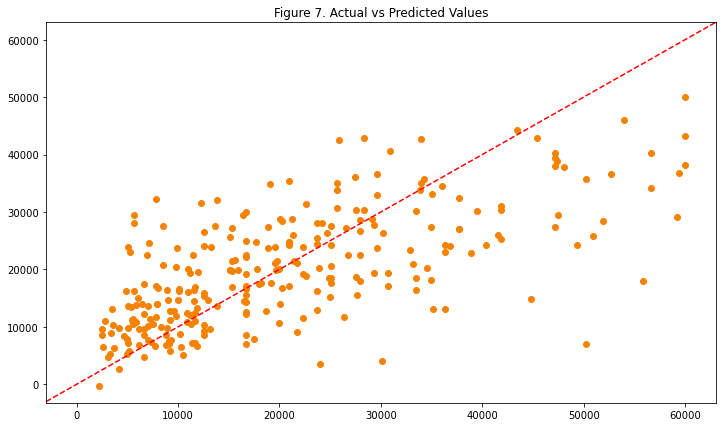

In [97]:
fig, ax = plt.subplots(figsize=(12,7))

ax = plt.scatter(y_val_mae, y_pred_mae, c='#f48304')
plt.axline([0, 0], [max(y_val_mae), max(y_val_mae)], color='r', linestyle='--')
plt.title('Figure 7. Actual vs Predicted Values');
plt.show()

In [98]:
xgb_results = pd.DataFrame({'actual': y_val_mae,
                            'pred': y_pred_mae})

q1 = xgb_results[xgb_results['actual'] <= xgb_results['actual'].quantile(0.25)]
q2 = xgb_results[(xgb_results['actual'] > xgb_results['actual'].quantile(0.25)) & 
                 (xgb_results['actual'] <= xgb_results['actual'].quantile(0.55))]
q3 = xgb_results[(xgb_results['actual'] > xgb_results['actual'].quantile(0.55)) &
                 (xgb_results['actual'] <= xgb_results['actual'].quantile(0.75))]
q4 = xgb_results[xgb_results['actual'] > xgb_results['actual'].quantile(0.75)]


quartile = pd.DataFrame({'Minimum': [0, xgb_results['actual'].quantile(0.25),
                                        xgb_results['actual'].quantile(0.50), 
                                        xgb_results['actual'].quantile(0.75)],
                         'Shape': [q1.shape, q2.shape, q3.shape, q4.shape],
                         'Mean': [np.mean(q1['actual']), np.mean(q2['actual']),
                                  np.mean(q3['actual']), np.mean(q4['actual'])],
                         'MAE' : [mean_absolute_error(q1['actual'], q1['pred']),
                                  mean_absolute_error(q2['actual'], q2['pred']),
                                  mean_absolute_error(q3['actual'], q3['pred']),
                                  mean_absolute_error(q4['actual'], q4['pred'])]},
                       index=[1,2,3,4])

quartile

,Minimum,Shape,Mean,MAE
1,0.0,"(69, 2)",6213.043478,6442.278205
2,9216.0,"(79, 2)",13927.569620,5547.392387
3,16754.0,"(55, 2)",23624.272727,5879.128813
4,27923.0,"(67, 2)",40833.970149,13014.164175


Investigating the error further, we viewed the error across the different quartiles of the holdout set to identify which salary range it is having difficulty predicting. Results showed that Q1 had an MAE of 6442.28, Q2 had 5547.39, Q3, had 5879.12, and Q4 had 13014.16 see table above. 

This then states that the model can predict the salary of those within the third quartile with an acceptable salary range of +/- 25% of their actual salary. This is a realistic scenario given that people within that salary range can have offers that differ 25% from each other. The same can be said in the 4th quartile where the MAE will result in a salary range that is +/-32% of their expected salary since a higher salary will expect a higher difference in the possible offers. However, the model is still unreliable in predicting salaries within the first quartile. This can be due to the various possible factors behind the low salary that is not reflected in the data. This can also be seen in quartile two but not to the same extent. It can also be observed visually in the figure 7 that the model overestimates the salary at the lower amounts and underestimates at the higher amounts. Hence, additional features may be needed to obtain even better results.


In [99]:
X_train_2 = pd.DataFrame(X_train_feed, columns=X_train.drop(columns=['Country'], axis=0).columns)

## IV.D.  XGBoost Interpretation using SHAP

The R2 of 0.45 shows that the model is still able to predict better than a baseline of simply taking the average. Yet, beyond its predictive ability, the model allows us to identify the features that contribute to a certain salary. Using SHAP, we were able to identify the different drivers of one’s compensation.

In [100]:
explainer_xgb = shap.Explainer(xgbr)
shap_values = explainer_xgb.shap_values(X_train_2)
shap_values_2 = explainer_xgb(X_train_2)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


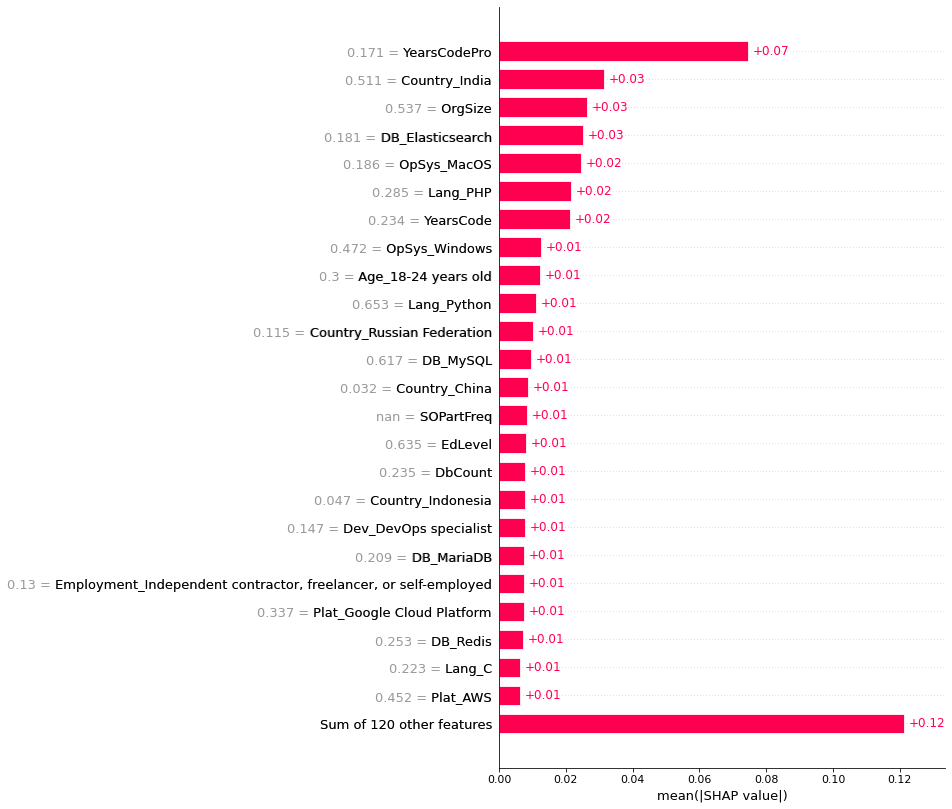

In [103]:
shap.plots.bar(shap_values_2, max_display=25, show_data=True)

In [105]:
X_val_col = X_val_final.rename(columns={
    'YearsCodePro': 'Years Coding Pro', 
    'YearsCode': 'Years Coding',
    'Country_India': 'In India',
    'OrgSize': 'Company Size',
    'SOPartFreq': 'StackOverflow Partcipation',
    'DbCount': "Database used",
    'Lang_PHP': 'PHP',
    'Lang_Python': 'Python',
    'DB_Elasticsearch': 'Elasticsearch',
    'OpSys_MacOS': 'MacOS user',
    'DCount': 'No. of job titles',
    'Age_18-24 years old': 'Age 18-24',
    'Plat_AWS': 'AWS', 
    'Country_Russian Federation': 'In Russia', 
    'DB_MySQL': 'MySQL',
    'EdLevel': 'Education level',
    'Employment_Independent contractor, freelancer, or self-employed': 'Self-employed',
    'OpSys_Windows': 'Windows user',
    'Plat_Google Cloud Platform': 'Google Cloud Platform',
    'Country_China': 'In China',
    'Country_Indonesia': 'In Indonesia',
    'Dev_DevOps specialist': 'DevOps specialist',
    'DB_MariaDB': 'MariaDB'})

X_val_col

,Age 18-24,Age_25-34 years old,Age_35-44 years old,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,Country_Afghanistan,Country_Armenia,Country_Azerbaijan,...,Plat_DigitalOcean,Google Cloud Platform,Plat_Heroku,Plat_IBM Cloud or Watson,Plat_Microsoft Azure,Plat_Oracle Cloud Infrastructure,Plat_other,StackOverflow Partcipation,Years Coding,Years Coding Pro
16903,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0.0,10.0,5.0
83431,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,2.0,9.0,4.0
36108,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.0,7.0,4.0
57243,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,3.0,8.0,4.0
58039,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.0,9.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44943,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.0,10.0,5.0
23170,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.0,5.0,0.5
67539,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1.0,6.0,3.0
58019,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,2.0,12.0,6.0


## IV.D.1. Global Interpretability

We can observe from figure 8 that years of coding as a professional is the top driver of salary. Intuitively, it makes sense that the longer you have been coding professionally, the higher your salary will be. The same can be said with years coding overall but not within the same extent. Another thing that appears to be directly proportional with salary is company wherein the bigger the company, the bigger the salary is. 

In terms of skills and tools, we have observed that the PHP language negatively affects salary. This can be because PHP is a common skill among developers hence does not have as much negotiating power as more specialized skills. This then brings us to the only language that is part of the top 15 drivers of salary: Python. The SHAP results showed that knowing Python positively impacts salary possibly due to the increasing demand for Python programmers. Elasticsearch as a database is also a positive predictor of salary while MySQL is a negative predictor. Other tools such as cloud platforms did not make it to the cut of top 15 predictors of salary.

One interesting result involves countries that made it to SHAP’s top 15 features. Among the 33 developing asian countries included, only India, Russia, and China made it to the top 15 with India having the 2nd largest impact on the model. Working in India appears to be negatively contributing to salary. This is possibly because of the high number of data practitioners in the country causing the demand to be saturated. This in turn lowers the negotiating power of programmers to ask for higher pay. A more suitable country for data practitioners looking to work abroad would be China which strongly adds to the SHAP value of the model. Russia is also a potential destination for those seeking to work abroad since it also positively contributes to the salary. Lastly, we have observed that education is also a factor in increasing your salary but only at a certain point. 

#### Figure 8. SHAP Bee Swarm

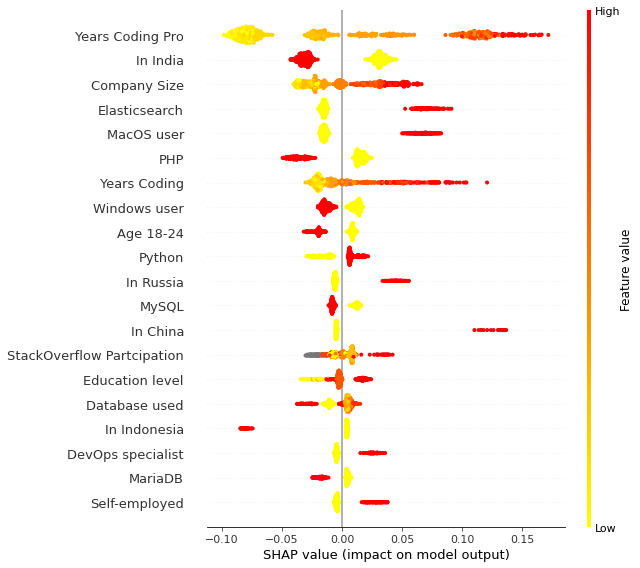

In [106]:
shap.summary_plot(shap_values = shap_values, features = X_train_2, 
                  feature_names=X_val_col.columns, cmap=plt.get_cmap('autumn_r'),
                  max_display=20)

In [107]:
df_encoded[df_encoded['Country']=='India']

,MainBranch,EdLevel,YearsCode,YearsCodePro,OrgSize,SOPartFreq,ConvertedCompYearly,Employment_Employed full-time,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed",...,DB_DynamoDB,DB_other,DB_Cassandra,DB_Couchbase,DB_IBM DB2,LCount,DCount,PCount,DbCount,Country
154,1,5,20.0,7.0,1,4.0,2340,0,0,1,...,0,0,0,0,0,7,8,1,5,India
554,1,5,3.0,1.0,1,3.0,11724,0,0,1,...,0,0,0,0,0,9,9,2,3,India
571,1,5,10.0,8.0,3,3.0,29320,1,0,0,...,1,0,0,0,0,10,7,1,7,India
586,1,5,3.0,0.5,8,2.0,6981,1,0,0,...,0,1,0,0,0,3,1,1,1,India
745,1,5,2.0,1.0,4,1.0,5868,0,0,1,...,0,0,0,0,0,9,2,2,2,India
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82525,1,5,5.0,2.0,6,1.0,60312,1,0,0,...,0,0,0,0,0,5,5,1,2,India
82534,0,5,15.0,12.0,9,NaN,23460,1,0,0,...,0,0,0,0,0,3,2,1,1,India
82749,1,5,7.0,4.0,2,1.0,9773,1,0,0,...,0,0,0,0,0,4,2,1,2,India
83046,0,6,14.0,11.0,4,4.0,13962,1,0,0,...,0,0,0,0,0,5,7,2,4,India


In [109]:
q1['quantile'] = 1
q2['quantile'] = 2
q3['quantile'] = 3
q4['quantile'] = 4

q1['MAE'] = abs(q1['actual'] - q1['pred'])
q2['MAE'] = abs(q2['actual'] - q2['pred'])
q3['MAE'] = abs(q3['actual'] - q3['pred'])
q4['MAE'] = abs(q4['actual'] - q4['pred'])

df_quantiles = pd.concat([q1,q2,q3,q4])
no_4 = df_quantiles[df_quantiles['quantile'] != 4]

print('Average: ', np.mean(no_4['actual']))
print('MAE:     ', mean_absolute_error(no_4['actual'], no_4['pred']))

Average:  13932.576354679803
MAE:      5941.444726126535



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

## IV.D.2. Local Interpretability

### Case 1: Non-MSDS

In [110]:
mandy = pd.DataFrame(columns=X_val_final.columns, index=[0])
mandy['Age_25-34 years old'] = 1
mandy['Country_Philippines'] = 1
mandy['Country_India'] = 0
mandy['YearsCode'] = 2
mandy['YearsCodePro'] = 0
mandy['EdLevel'] = 5
mandy['OrgSize'] = 6
mandy['DB_MongoDB'] = 0
mandy['DB_PostgreSQL'] = 1
mandy['DB_SQLite'] = 1
mandy['Dev_Data or business analyst'] = 0
mandy['Dev_Data scientist or machine learning specialist'] = 0
mandy['Dev_Database administrator'] = 0
mandy['Dev_Developer, back-end'] = 0
mandy['Dev_Developer, front-end'] = 0
mandy['Dev_Developer, full-stack'] = 0
mandy['Dev_Developer, mobile'] = 1
mandy['Dev_Engineer, data'] = 0
mandy['Employment_Employed full-time'] = 1
mandy['Employment_Independent contractor, freelancer, or self-employed'] = 0
mandy['Lang_JavaScript'] = 0
mandy['Lang_PHP'] = 0
mandy['Lang_Python'] = 0
mandy['Lang_R'] = 0
mandy['Lang_SQL'] = 1
mandy['Plat_Heroku'] = 0
mandy['Plat_AWS'] = 0
mandy['Plat_Google Cloud Platform'] = 0
mandy['LCount'] = 1
mandy['PCount'] = 0
mandy['DbCount'] = 2
mandy['DCount'] = 1

mandy = mandy.fillna(0)
mandy

,Age_18-24 years old,Age_25-34 years old,Age_35-44 years old,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,Country_Afghanistan,Country_Armenia,Country_Azerbaijan,...,Plat_DigitalOcean,Plat_Google Cloud Platform,Plat_Heroku,Plat_IBM Cloud or Watson,Plat_Microsoft Azure,Plat_Oracle Cloud Infrastructure,Plat_other,SOPartFreq,YearsCode,YearsCodePro
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


#### Figure 9. Force Plot for Non-MSDS

60012.0
[[1175320.]]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


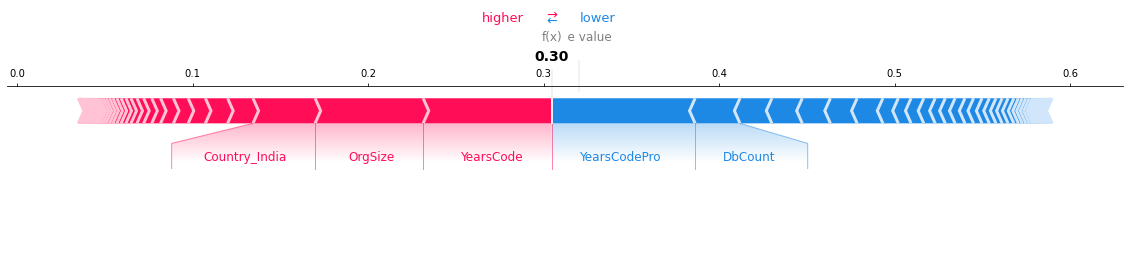

In [111]:
print(max(y_val_mae))
print(y_pred_dict.get('Philippines')[2].inverse_transform(np.array(xgbr.predict(mandy)).reshape(-1,1)) * 50)

explainer_xgb = shap.TreeExplainer(xgbr)
shap_values_m = explainer_xgb.shap_values(mandy)
shap.force_plot(explainer_xgb.expected_value, 
                shap_values_m, mandy.columns, matplotlib=True)

### Case 2: MSDS

In [112]:
mandy = pd.DataFrame(columns=X_val_final.columns, index=[0])
mandy['Age_25-34 years old'] = 1
mandy['Country_Philippines'] = 1
mandy['Country_India'] = 0
mandy['YearsCode'] = 2
mandy['YearsCodePro'] = 0
mandy['EdLevel'] = 6
mandy['OrgSize'] = 6
mandy['DB_MongoDB'] = 0
mandy['DB_PostgreSQL'] = 1
mandy['DB_SQLite'] = 1
mandy['Dev_Data or business analyst'] = 0
mandy['Dev_Data scientist or machine learning specialist'] = 1
mandy['Dev_Database administrator'] = 0
mandy['Dev_Developer, back-end'] = 0
mandy['Dev_Developer, front-end'] = 0
mandy['Dev_Developer, full-stack'] = 0
mandy['Dev_Developer, mobile'] = 0
mandy['Dev_Engineer, data'] = 0
mandy['Employment_Employed full-time'] = 1
mandy['Employment_Independent contractor, freelancer, or self-employed'] = 0
mandy['Lang_JavaScript'] = 0
mandy['Lang_PHP'] = 0
mandy['Lang_Python'] = 1
mandy['Lang_R'] = 0
mandy['Lang_SQL'] = 1
mandy['Plat_Heroku'] = 0
mandy['Plat_AWS'] = 1
mandy['Plat_Google Cloud Platform'] = 0
mandy['LCount'] = 2
mandy['PCount'] = 1
mandy['DbCount'] = 2
mandy['DCount'] = 1

mandy = mandy.fillna(0)
mandy

,Age_18-24 years old,Age_25-34 years old,Age_35-44 years old,Age_45-54 years old,Age_55-64 years old,Age_Prefer not to say,Age_Under 18 years old,Country_Afghanistan,Country_Armenia,Country_Azerbaijan,...,Plat_DigitalOcean,Plat_Google Cloud Platform,Plat_Heroku,Plat_IBM Cloud or Watson,Plat_Microsoft Azure,Plat_Oracle Cloud Infrastructure,Plat_other,SOPartFreq,YearsCode,YearsCodePro
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


#### Figure 10. Force Plot for MSDS

60012.0
[[1364199.]]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


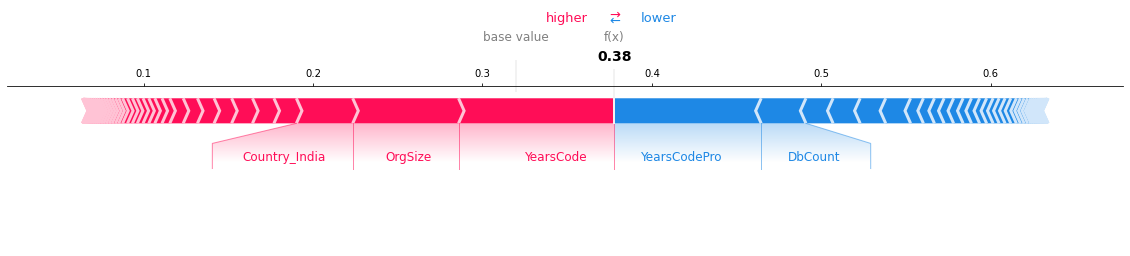

In [113]:
print(max(y_val_mae))
print(y_pred_dict.get('Philippines')[2].inverse_transform(np.array(xgbr.predict(mandy)).reshape(-1,1)) * 50)

explainer_xgb = shap.TreeExplainer(xgbr)
shap_values_m = explainer_xgb.shap_values(mandy)
shap.force_plot(explainer_xgb.expected_value, 
                shap_values_m, mandy.columns, matplotlib=True)

Narrowing down our interpretation to individual predictions, we looked at the features that affect the salary of an individual living in the Philippines with the skillset of a Master’s in Data Science fresh graduate. Our model predicted this individual to have a salary of 27254. This is mainly driven by them having 2 years of coding experience, working for a midsize company, and living in the Philippines (figure 9). Having no years of professional coding pushed back his salary. If we change the individual to having at least 2 years of professional coding experience, his salary would jump to 38561 as years of professional coding pushes his salary higher (figure 10). 


Our model shows that one’s salary is a mix of both factors that you can immediately control (e.g. skills, tools, education level) and cannot immediately control (e.g. years coding, country), with those that you cannot control being stronger drivers of salary. 



# Conclusions and Recommendations

The iterations and hypertuned models predicted a monthly salary give or take USD 600. The resulting MAE can be attributed to 1.) the potentially subjective nature of this dataset and 2.) the large variance in the last quartile of salaries. The dataset also featured more points in some countries over others, making it difficult to generalize in countries with fewer data points. This was also reflected in the SHAP results. For instance, being from the Philippines as a feature, which had 29 total respondents in our data specific to data scientists, had virtually no impact on the model, while the number of respondents from India, which featured almost half of the used dataset, ranked second in the SHAP plot. Even with stratified splitting, countries like the Philippines would have fewer data points to train the model on. However, this does not entirely remove the validity of the interpretability methods, as the best model, XGBoost, attained an R-squared of 0.45, implying that nearly half of the model’s variation can be explained by the features, 45% better than a baseline method of predicting the values. 

The factors with the largest impacts involve things typically outside a person’s control. But, factors such as education (up to a certain point), knowing Python, and choosing which country to migrate to, all have an important role to play in increasing one’s salary as a data scientist from developing Asia. As such, pursuing a higher education, learning how to code in Python, and possibly migrating to Russia can be conditional recommendations for aspiring data scientists from developing Asia. However, the study cannot claim causality with regards to the SHAP results, again due to the subjective nature of the data.  

One way to improve this study for future purposes would be to include data from websites such as Glassdoor and LinkedIn. A survey with better and sufficient representation across all countries would enable the creation of a model that can better capture what it means to be a data scientist across the globe. Finally, other machine learning methods that involve deep learning, may result in more accurate predictions than the methods currently being used by the researchers.

Indeed, data science is more than just a few buzzwords on the internet. While Harvard Business Review dubbed this field as the sexiest job of the 21st century, it isn’t so simple to model and say with 100% certainty which factors play a role. However, the results are sufficient to claim that our model’s top SHAP’s features do reflect reality. Beyond the numbers the metrics give us, being a good data scientist means having a holistic understanding of the data they work with, the models they use, the critical assumptions, the business value, and the best way to communicate the findings with key stakeholders. 
